# 1. Các thư viện cần thiết

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

from sklearn.model_selection import cross_val_score, KFold, cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor, plot_importance

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

import matplotlib.pyplot as plt
import seaborn as sns

import os
import time

StatementMeta(, 70b6eae9-aaeb-442b-94e4-6cfce5628bb2, 3, Finished, Available, Finished)

# 2. Khám phá dữ liệu

In [ ]:
ecommerce_data = {}
parent_folder = "/lakehouse/default/Files/ecommerce_data_generated" # Đổi đường dẫn này thành folder chứa data trong máy
for file in os.listdir(parent_folder):
    if file.endswith('.csv'):
        file_path = os.path.join(parent_folder, file)
        table_name = file.replace('.csv', '')
        ecommerce_data[table_name] = pd.read_csv(file_path)
        print(f"Sample of {table_name}:")
        display(ecommerce_data[table_name].head())

StatementMeta(, 70b6eae9-aaeb-442b-94e4-6cfce5628bb2, 4, Finished, Available, Finished)

Sample of customers:


SynapseWidget(Synapse.DataFrame, 77933293-60d4-434b-a735-39e8515aa997)

Sample of order_items:


SynapseWidget(Synapse.DataFrame, 174a32f0-1893-4451-aacc-984714200cfc)

Sample of order_payments:


SynapseWidget(Synapse.DataFrame, f5960492-3692-439f-8f19-599f02afdfee)

Sample of order_reviews:


SynapseWidget(Synapse.DataFrame, 135c21b2-d1fa-4404-af75-9f7da6c1b582)

Sample of orders:


SynapseWidget(Synapse.DataFrame, 8c323602-82e1-4b6c-9763-c674afab8c34)

Sample of products:


SynapseWidget(Synapse.DataFrame, c73f24ca-271e-41ae-a893-69701c9b7d33)

Sample of sellers:


SynapseWidget(Synapse.DataFrame, 5e2ab83b-8ef4-4182-9626-28ca995ccdaf)

## Kiểm tra kiểu dữ liệu

In [ ]:
for name, value in ecommerce_data.items():
    print(f"Điều tra bảng {name}:")
    print(value.info())
    # Kiểm tra giá trị thiếu
    missing_counts = value.isna().sum()
    missing_counts = missing_counts[missing_counts > 0]
    if missing_counts.empty:
        print(f"Bảng {name} không có giá trị thiếu nào")
    else:
        missing_percentage = (missing_counts / len(value))*100
        missing_df = pd.DataFrame({
            'Số lượng thiếu': missing_counts,
            'Tỷ lệ thiếu (%)': missing_percentage.round(2)
        }).sort_values(by='Số lượng thiếu', ascending=False)
        print(missing_df)

StatementMeta(, 70b6eae9-aaeb-442b-94e4-6cfce5628bb2, 5, Finished, Available, Finished)

Điều tra bảng customers:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               50000 non-null  object 
 1   customer_unique_id        50000 non-null  object 
 2   customer_zip_code_prefix  50000 non-null  object 
 3   customer_city             50000 non-null  object 
 4   customer_lat              50000 non-null  float64
 5   customer_lng              50000 non-null  float64
dtypes: float64(2), object(4)
memory usage: 2.3+ MB
None
Bảng customers không có giá trị thiếu nào
Điều tra bảng order_items:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1980972 entries, 0 to 1980971
Data columns (total 7 columns):
 #   Column               Dtype 
---  ------               ----- 
 0   order_id             object
 1   order_item_id        int64 
 2   product_id           object
 3   seller_id          

### 1. Bảng `customers` (Khách hàng)

| Tên cột | Ý nghĩa |
| :--- | :--- |
| `customer_id` | ID định danh của khách hàng (liên kết với một đơn hàng cụ thể). |
| `customer_unique_id` | ID định danh **duy nhất** cho một khách hàng (dùng để theo dõi qua nhiều đơn hàng). |
| `customer_zip_code_prefix` | 5 chữ số đầu của mã bưu điện (ZIP code) của khách hàng. |
| `customer_city` | Tên thành phố của khách hàng. |
| `customer_lat`  | Tọa độ địa chỉ của khách hàng.|
| `customer_lng`  | Tọa độ địa chỉ của khách hàng.|

### 2. Bảng `orders` (Đơn hàng)

| Tên cột | Ý nghĩa |
| :--- | :--- |
| `order_id` | ID định danh **duy nhất** cho mỗi đơn hàng (Khóa chính). |
| `customer_id` | ID của khách hàng đã đặt đơn hàng (Nối tới bảng `customers`). |
| `order_status` | Trạng thái của đơn hàng (ví dụ: `delivered`, `shipped`, `canceled`). |
| `order_purchase_timestamp` | Dấu thời gian khi khách hàng **thực hiện mua hàng**. |
| `order_approved_at` | Dấu thời gian khi thanh toán **được phê duyệt**. |
| `order_delivered_carrier_date`| Dấu thời gian khi đơn hàng **được giao cho đơn vị vận chuyển**. |
| `order_delivered_customer_date`| Dấu thời gian khi đơn hàng **được giao thành công** đến khách hàng. |
| `order_estimated_delivery_date`| Ngày **dự kiến** giao hàng. |

### 3. Bảng `order_items` (Các mục trong đơn hàng)

| Tên cột | Ý nghĩa |
| :--- | :--- |
| `order_id` | ID của đơn hàng (Nối tới bảng `orders`). |
| `order_item_id` | Số thứ tự của sản phẩm *trong cùng một đơn hàng* (ví dụ: 1, 2, 3...). |
| `product_id` | ID của sản phẩm (Nối tới bảng `products`). |
| `seller_id` | ID của người bán sản phẩm này (Nối tới bảng `sellers`). |
| `shipping_limit_date` | Hạn chót người bán phải giao hàng cho đơn vị vận chuyển. |
| `price` | Giá của sản phẩm này. |
| `freight_value` | Phí vận chuyển cho sản phẩm này. |

### 4. Bảng `order_payments` (Thanh toán đơn hàng)

| Tên cột | Ý nghĩa |
| :--- | :--- |
| `order_id` | ID của đơn hàng (Nối tới bảng `orders`). |
| `payment_sequential` | Thứ tự thanh toán (nếu 1 đơn hàng dùng nhiều hình thức). |
| `payment_type` | Loại hình thanh toán. |
| `payment_installments` | Số kỳ trả góp (ví dụ: 1 là trả một lần). |
| `payment_value` | Giá trị của lần thanh toán này. |

### 5. Bảng `order_reviews` (Đánh giá đơn hàng)

| Tên cột | Ý nghĩa |
| :--- | :--- |
| `review_id` | ID định danh duy nhất cho mỗi đánh giá. |
| `order_id` | ID của đơn hàng được đánh giá (Nối tới bảng `orders`). |
| `review_score` | Điểm đánh giá (thường là từ 1 đến 5 sao). |
| `review_creation_date` | Dấu thời gian khi khách hàng **gửi** đánh giá. |
| `review_answer_timestamp` | Dấu thời gian khi người bán (hoặc hệ thống) **phản hồi** đánh giá. |

### 6. Bảng `products` (Sản phẩm)

| Tên cột | Ý nghĩa |
| :--- | :--- |
| `product_id` | ID định danh duy nhất cho mỗi sản phẩm (Khóa chính). |
| `product_category_name` | Tên danh mục của sản phẩm. |
| `product_price_vnd` | Giá của sản phẩm (đã quy đổi sang VND). |
| `product_weight_g` | Cân nặng của sản phẩm, tính bằng **gram (g)**. |
| `product_length_cm` | Chiều dài của sản phẩm/kiện hàng, tính bằng **centimet (cm)**. |
| `product_height_cm` | Chiều cao của sản phẩm/kiện hàng, tính bằng **centimet (cm)**. |
| `product_width_cm` | Chiều rộng của sản phẩm/kiện hàng, tính bằng **centimet (cm)**. |

### 7. Bảng `sellers` (Người bán)

| Tên cột | Ý nghĩa |
| :--- | :--- |
| `seller_id` | ID định danh duy nhất cho mỗi người bán. |
| `seller_zip_code_prefix` | 5 chữ số đầu mã bưu điện của người bán. |
| `seller_city` | Thành phố của người bán. |
| `seller_lat`  | Tọa độ địa chỉ của người bán.|
| `seller_lng`  | Tọa độ địa chỉ của người bán.|

![image.png](attachment:image.png)


Các cột dữ liệu của các bảng đều ở đúng định dạng, trừ các trường dữ liệu liên quan đén thời gian. Bảng `order` có 3 trường dữ liệu bị thiếu dữ liệu, cần điều tra sâu hơn.

Đồng thời, có thể thấy bảng `order_reviews` không cần thiết cho đề tài này, có thể loại bỏ.

## Kiểm tra dữ liệu thiếu

In [ ]:
order_data = ecommerce_data['orders'].copy()
order_data.head()

StatementMeta(, 70b6eae9-aaeb-442b-94e4-6cfce5628bb2, 6, Finished, Available, Finished)

order_id     customer_id order_status    order_purchase_timestamp  \
0  order_0  customer_22395    delivered  2023-04-11 08:35:38.830894   
1  order_1  customer_32991    delivered  2025-04-10 23:15:20.283280   
2  order_2  customer_35555    delivered  2022-08-05 10:49:18.975113   
3  order_3  customer_34563    delivered  2024-11-02 16:26:09.832499   
4  order_4  customer_49386    delivered  2024-08-06 20:08:05.124582   

            order_approved_at order_delivered_carrier_date  \
0  2023-04-11 09:49:38.830894   2023-04-11 11:49:38.830894   
1  2025-04-11 00:07:20.283280   2025-04-11 03:07:20.283280   
2  2022-08-05 12:12:18.975113   2022-08-05 20:12:18.975113   
3  2024-11-02 16:58:09.832499   2024-11-03 15:58:09.832499   
4  2024-08-06 20:36:05.124582   2024-08-08 05:36:05.124582   

  order_delivered_customer_date order_estimated_delivery_date  
0    2023-04-13 17:45:39.438337    2023-04-17 08:35:38.830894  
1    2025-04-14 08:42:47.175983    2025-04-17 23:15:20.283280  
2    2022-08-07 22:54:56.913903    2022-08-11 10:49:18.975113  
3    2024-11-05 07:54:54.246058    2024-11-07 16:26:09.832499  
4    2024-08-10 01:24:28.271814    2024-08-11 20:08:05.124582

In [ ]:
missing_counts = order_data.isna().sum()
missing_counts = missing_counts[missing_counts > 0]
missing_percentage = (missing_counts / len(order_data))*100
missing_df = pd.DataFrame({
    'Số lượng thiếu': missing_counts,
    'Tỷ lệ thiếu (%)': missing_percentage.round(2)
}).sort_values(by='Số lượng thiếu', ascending=False)
missing_df

StatementMeta(, 70b6eae9-aaeb-442b-94e4-6cfce5628bb2, 7, Finished, Available, Finished)

Số lượng thiếu  Tỷ lệ thiếu (%)
order_delivered_customer_date          192679            19.27
order_delivered_carrier_date           164345            16.43
order_approved_at                       69168             6.92

Dưới đây là ý nghĩa của các trường dữ liệu bị thiếu thông tin:
- `order_approved_at`:  Dấu thời gian khi thanh toán **được phê duyệt**.
- `order_delivered_carrier_date`: Dấu thời gian khi đơn hàng **được giao cho đơn vị vận chuyển**.
- `order_delivered_customer_date`: Dấu thời gian khi đơn hàng **được giao thành công** đến khách hàng.

### Điều tra xem dữ liệu bị thiếu nằm ở đâu

In [ ]:
# Đối với cột `order_delivered_customer_date`
missing_delivered_date = order_data[order_data['order_delivered_customer_date'].isna()]
display(missing_delivered_date.head())
print(missing_delivered_date.info())

StatementMeta(, 70b6eae9-aaeb-442b-94e4-6cfce5628bb2, 8, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, cb977b1a-ef77-49eb-80cb-aa15b06dc68e)

<class 'pandas.core.frame.DataFrame'>
Index: 192679 entries, 5 to 999985
Data columns (total 8 columns):
 #   Column                         Non-Null Count   Dtype 
---  ------                         --------------   ----- 
 0   order_id                       192679 non-null  object
 1   customer_id                    192679 non-null  object
 2   order_status                   192679 non-null  object
 3   order_purchase_timestamp       192679 non-null  object
 4   order_approved_at              123511 non-null  object
 5   order_delivered_carrier_date   28334 non-null   object
 6   order_delivered_customer_date  0 non-null       object
 7   order_estimated_delivery_date  192679 non-null  object
dtypes: object(8)
memory usage: 13.2+ MB
None


In [ ]:
# Kiểm tra trạng thái của các đơn hàng không có ngày nhận hàng
missing_delivered_order_status = missing_delivered_date.groupby("order_status").size().reset_index(name="Số lượng đơn")
total_missing = len(missing_delivered_date)
missing_delivered_order_status['%'] = (missing_delivered_order_status['Số lượng đơn'] / total_missing) * 100
missing_delivered_order_status['%'] = missing_delivered_order_status['%'].round(2)
missing_delivered_order_status = missing_delivered_order_status.sort_values(by='Số lượng đơn', ascending=False)
print(missing_delivered_order_status)

StatementMeta(, 70b6eae9-aaeb-442b-94e4-6cfce5628bb2, 9, Finished, Available, Finished)

  order_status  Số lượng đơn      %
0     canceled        100142  51.97
1    delivered         42737  22.18
2      shipped         29811  15.47
3  unavailable         19989  10.37


=> Có thể hiểu các đơn hàng không có ngày khách hàng nhận hàng là các đơn hàng bị hủy, có thể bởi cả bên người mua (`canceled`) hoặc người bán (`unavailable`). Tuy nhiên, vẫn sẽ có những đơn hàng với trạng thái là Đã được giao nhưng lại không có ngày nhận hàng (chiếm tỷ lệ 22.18%).

Đối với những đơn hàng Đã được giao (`delievered`) và Đã được đưa cho bên vận chuyển (`shipped`), có thể coi Ngày giao hàng dự kiến (`order_estimated_delivery_date`) chính là Ngày giao hàng của các đơn hàng đó.

In [ ]:
# Đối với cột `order_delivered_carrier_date`
missing_carrier_date = order_data[order_data['order_delivered_carrier_date'].isna()]
display(missing_carrier_date.head())
print(missing_carrier_date.info())

StatementMeta(, 70b6eae9-aaeb-442b-94e4-6cfce5628bb2, 10, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, ce4e03da-8ba2-4c14-9835-44be8c1025b0)

<class 'pandas.core.frame.DataFrame'>
Index: 164345 entries, 5 to 999985
Data columns (total 8 columns):
 #   Column                         Non-Null Count   Dtype 
---  ------                         --------------   ----- 
 0   order_id                       164345 non-null  object
 1   customer_id                    164345 non-null  object
 2   order_status                   164345 non-null  object
 3   order_purchase_timestamp       164345 non-null  object
 4   order_approved_at              95177 non-null   object
 5   order_delivered_carrier_date   0 non-null       object
 6   order_delivered_customer_date  0 non-null       object
 7   order_estimated_delivery_date  164345 non-null  object
dtypes: object(8)
memory usage: 11.3+ MB
None


Có thể thấy, các dòng bị thiếu `order_delivered_carrier_date` (0 non-null) thì cũng thiếu `order_delivered_customer_date`.

In [ ]:
missing_carrier_order_status = missing_carrier_date.groupby("order_status").size().reset_index(name="Số lượng đơn")
total_missing = len(missing_carrier_date)
missing_carrier_order_status['%'] = (missing_carrier_order_status['Số lượng đơn'] / total_missing) * 100
missing_carrier_order_status['%'] = missing_carrier_order_status['%'].round(2)
missing_carrier_order_status = missing_carrier_order_status.sort_values(by='Số lượng đơn', ascending=False)
print(missing_carrier_order_status)

StatementMeta(, 70b6eae9-aaeb-442b-94e4-6cfce5628bb2, 11, Finished, Available, Finished)

  order_status  Số lượng đơn      %
0     canceled        100142  60.93
1    delivered         42737  26.00
3  unavailable         19989  12.16
2      shipped          1477   0.90


=> Với những đơn ghi trạng thái là Đã giao (delivered và shipped) nhưng không có ngày giao cho bên vận chuyển (`order_delivered_carrier_date`) thì có thể sử dụng ngày hạn chót người bán phải gửi nhận đơn hàng là ngày giao cho bên vận chuyển `shipping_limit_date`.

In [ ]:
# Đối với cột `order_approved_at`
missing_approved_date = order_data[order_data['order_approved_at'].isna()]
display(missing_approved_date.head())
print(missing_approved_date.info())

StatementMeta(, 70b6eae9-aaeb-442b-94e4-6cfce5628bb2, 12, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 85c144fe-5280-45d2-ae68-cffd3023b1ac)

<class 'pandas.core.frame.DataFrame'>
Index: 69168 entries, 87 to 999985
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       69168 non-null  object
 1   customer_id                    69168 non-null  object
 2   order_status                   69168 non-null  object
 3   order_purchase_timestamp       69168 non-null  object
 4   order_approved_at              0 non-null      object
 5   order_delivered_carrier_date   0 non-null      object
 6   order_delivered_customer_date  0 non-null      object
 7   order_estimated_delivery_date  69168 non-null  object
dtypes: object(8)
memory usage: 4.7+ MB
None


Có thể thấy, các dòng bị thiếu `order_delivered_carrier_date` (0 non-null) thì cũng thiếu `order_delievered_carrier_date` và `order_delivered_customer_date`.

In [ ]:
missing_approved_order_status = missing_approved_date.groupby("order_status").size().reset_index(name="Số lượng đơn")
total_missing = len(missing_approved_date)
missing_approved_order_status['%'] = (missing_approved_order_status['Số lượng đơn'] / total_missing) * 100
missing_approved_order_status['%'] = missing_approved_order_status['%'].round(2)
missing_approved_order_status = missing_approved_order_status.sort_values(by='Số lượng đơn', ascending=False)
print(missing_approved_order_status)

StatementMeta(, 70b6eae9-aaeb-442b-94e4-6cfce5628bb2, 13, Finished, Available, Finished)

  order_status  Số lượng đơn      %
1    delivered         42737  61.79
3  unavailable         19989  28.90
0     canceled          4965   7.18
2      shipped          1477   2.14


In [ ]:
# Đối với các dòng dữ liệu bị thiếu của `order_approved_at`, cần điều tra sâu hơn, bằng cách tính hợp thêm thông tin thanh toán, do đây là ngày thanh toán được duyệt
payment_data = ecommerce_data['order_payments'].copy()
display(payment_data.head())
print(payment_data.info())

StatementMeta(, 70b6eae9-aaeb-442b-94e4-6cfce5628bb2, 14, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 268ad947-8220-432e-bb35-335e64794605)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990007 entries, 0 to 990006
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   order_id              990007 non-null  object
 1   payment_sequential    990007 non-null  int64 
 2   payment_type          990007 non-null  object
 3   payment_installments  990007 non-null  int64 
 4   payment_value         990007 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 37.8+ MB
None


In [ ]:
# Các hình thức thanh toán
print(payment_data['payment_type'].unique())

StatementMeta(, 70b6eae9-aaeb-442b-94e4-6cfce5628bb2, 15, Finished, Available, Finished)

['COD' 'vi_dien_tu' 'the_tin_dung' 'chuyen_khoan']


=> Với những đơn hàng mà thiếu ngày nhận thanh toán (`order_approved_at`) và có trạng thái là Đã giao (delivered) sẽ được điền theo 2 cách: nếu `payment_type` là COD thì sẽ được điền bằng ngày nhận hàng dự kiến hoặc ngày nhận hàng thực tế (vì khách chỉ có thể đưa tiền mặt cho shipper khi đã nhận được hàng), còn với các hình thức thanh toán khác thì sẽ được điền bằng ngày đơn hàng được chấp nhận (do đây là các phương thức thanh toán có thể thực hiện ngay trên điện thoại, gần như ngay lập tức tại thời điểm đặt hàng).

## Kiểm tra dữ liệu trùng lặp

In [ ]:
# Định nghĩa các cột khóa chính (primary key) cho từng bảng
# Đây là những cột mà giá trị phải là duy nhất trong bảng đó
primary_keys = {
    'orders': ['order_id'],
    'customers': ['customer_id'],
    'sellers': ['seller_id'],
    'products': ['product_id'],
    'order_reviews': ['review_id'],
    # Bảng order_items có thể có nhiều dòng cho cùng một order_id,
    # nhưng cặp (order_id, order_item_id) phải là duy nhất
    'order_items': ['order_id', 'order_item_id'],
    'order_payments': ['order_id', 'payment_sequential']
}
# Lặp qua từng bảng (DataFrame)
for table_name, df in ecommerce_data.items():
    print(f"Xét bảng {table_name:}")
    # Kiểm tra trùng lặp toàn bộ dòng
    full_row_duplicates = df.duplicated().sum()
    if full_row_duplicates > 0:
        print(f"Tìm thấy {full_row_duplicates} dòng bị trùng lặp hoàn toàn.")
    else:
        print("Không có dòng nào bị trùng lặp hoàn toàn.")

    # 2. Kiểm tra trùng lặp trên các cột khóa chính
    if table_name in primary_keys:
        key_columns = primary_keys[table_name]
        key_duplicates = df.duplicated(subset=key_columns).sum()
        if key_duplicates > 0:
            print(f"Tìm thấy {key_duplicates} giá trị trùng lặp trên cột khóa chính {key_columns}")
        else:
            print(f"Dữ liệu trên cột khóa chính {key_columns} là duy nhất")

StatementMeta(, 70b6eae9-aaeb-442b-94e4-6cfce5628bb2, 16, Finished, Available, Finished)

Xét bảng customers
Không có dòng nào bị trùng lặp hoàn toàn.
Dữ liệu trên cột khóa chính ['customer_id'] là duy nhất
Xét bảng order_items
Không có dòng nào bị trùng lặp hoàn toàn.
Dữ liệu trên cột khóa chính ['order_id', 'order_item_id'] là duy nhất
Xét bảng order_payments
Không có dòng nào bị trùng lặp hoàn toàn.
Dữ liệu trên cột khóa chính ['order_id', 'payment_sequential'] là duy nhất
Xét bảng order_reviews
Không có dòng nào bị trùng lặp hoàn toàn.
Dữ liệu trên cột khóa chính ['review_id'] là duy nhất
Xét bảng orders
Không có dòng nào bị trùng lặp hoàn toàn.
Dữ liệu trên cột khóa chính ['order_id'] là duy nhất
Xét bảng products
Không có dòng nào bị trùng lặp hoàn toàn.
Dữ liệu trên cột khóa chính ['product_id'] là duy nhất
Xét bảng sellers
Không có dòng nào bị trùng lặp hoàn toàn.
Dữ liệu trên cột khóa chính ['seller_id'] là duy nhất


## Kiểm tra logic của các cột

### Kiểm tra logic số

In [ ]:
# Kiểm tra các cột số có giá trị không đúng tiêu chuẩn nào không
for name, value in ecommerce_data.items():
    print(f"Xét bảng {name}:")
    numeric_df = value.select_dtypes(include='number')
    if numeric_df.empty:
        pass
    else:
        print(numeric_df.describe())

StatementMeta(, 70b6eae9-aaeb-442b-94e4-6cfce5628bb2, 17, Finished, Available, Finished)

Xét bảng customers:
       customer_lat  customer_lng
count  50000.000000  50000.000000
mean      15.527265    106.586872
std        4.780272      1.080395
min        9.003203    102.878940
25%       10.786389    105.850284
50%       15.141387    106.571944
75%       20.967319    106.811652
max       22.948104    109.407660
Xét bảng order_items:
       order_item_id         price  freight_value
count   1.980972e+06  1.980972e+06   1.980972e+06
mean    1.667076e+00  1.186136e+07   1.484068e+06
std     7.454888e-01  1.812945e+07   2.454841e+06
min     1.000000e+00  2.000000e+04   1.000000e+03
25%     1.000000e+00  6.300000e+05   7.100000e+04
50%     2.000000e+00  2.188000e+06   2.640000e+05
75%     2.000000e+00  1.650600e+07   1.810000e+06
max     3.000000e+00  7.999800e+07   1.597400e+07
Xét bảng order_payments:
       payment_sequential  payment_installments  payment_value
count            990007.0              990007.0   9.900070e+05
mean                  1.0                   1.0   2

=> Không có giá trị số nào bất thường về mặt logic tiêu chuẩn

### Kiểm tra logic giá trị đơn hàng

StatementMeta(, 70b6eae9-aaeb-442b-94e4-6cfce5628bb2, 18, Finished, Available, Finished)

/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


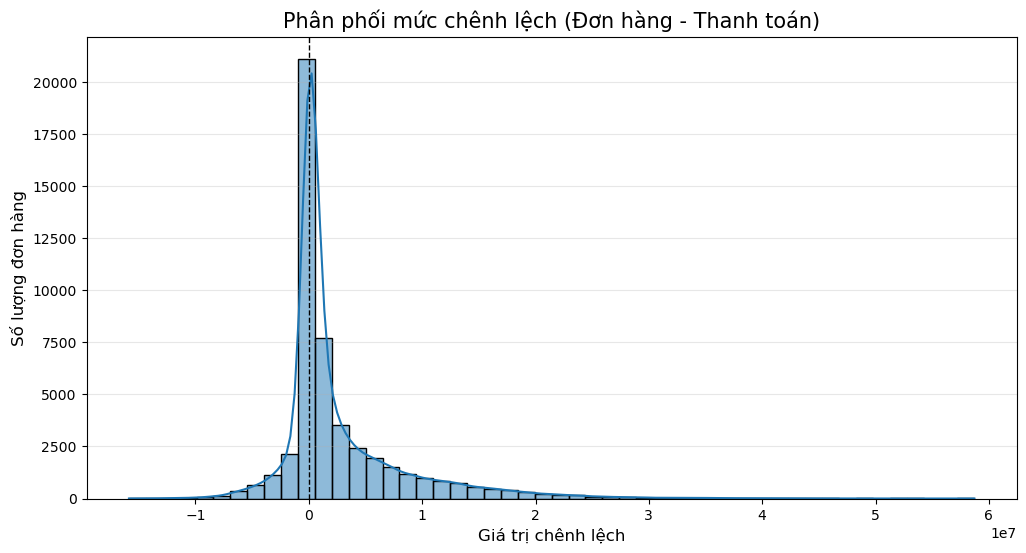

SynapseWidget(Synapse.DataFrame, 511f1d6b-f6a2-4cfb-b36e-a4c67d8ddc31)

In [ ]:
# Kiểm tra giá trị thanh toán của mỗi đơn hàng (order_id) có bằng tổng giá trị đơn hàng không
order_item_data = ecommerce_data['order_items'].copy()
payment_data = ecommerce_data['order_payments'].copy()
# Tổng hợp giá trị thanh toán theo từng đơn hàng
payment_data_grouped_order = payment_data.groupby('order_id')['payment_value'].sum()
payment_data_grouped_order = pd.DataFrame(payment_data_grouped_order).reset_index()
# Tổng hợp giá trị đơn hàng
order_item_data['total_value'] = order_item_data['price'] + order_item_data['freight_value']
order_item_data_grouped = order_item_data.groupby('order_id')['total_value'].sum()
order_item_data_grouped = pd.DataFrame(order_item_data_grouped).reset_index()
# Hợp 2 dataframe lại để so sánh
order_payment = pd.merge(order_item_data_grouped, payment_data_grouped_order, how='inner', on='order_id')
order_payment['value_diff'] = (order_payment['total_value'] - order_payment['payment_value']).round(0)
# Lọc những dòng có chênh lệch khác 0
payment_diff = order_payment[order_payment['value_diff']!=0]
if len(payment_diff)==0:
    print("Giá trị thanh toán khớp hoàn toàn với giá trị các đơn hàng")
else:
    print(f"Có {len(payment_diff)} đơn bị lệch giá trị đơn hàng và giá trị thanh toán")
    plt.figure(figsize=(12, 6))
    # Vẽ histogram
    sns.histplot(payment_diff['value_diff'], bins=50, kde=True)
    plt.title('Phân phối mức chênh lệch (Đơn hàng - Thanh toán)', fontsize=15)
    plt.xlabel('Giá trị chênh lệch', fontsize=12)
    plt.ylabel('Số lượng đơn hàng', fontsize=12)
    # Thêm đường kẻ dọc tại 0 để dễ so sánh
    plt.axvline(0, color='black', linestyle='--', linewidth=1)
    plt.grid(axis='y', alpha=0.3)
    plt.show()

    # Hiển thị bảng chi tiết
    display(payment_diff.sort_values(by='value_diff'))

In [ ]:
def is_negative(x):
    if x<0:
        return "negative"
    else:
        return "positive"
payment_diff['negative_or_positive'] = payment_diff['value_diff'].apply(is_negative)
group_payment_diff = payment_diff.groupby("negative_or_positive").size()
group_payment_diff

StatementMeta(, 70b6eae9-aaeb-442b-94e4-6cfce5628bb2, 19, Finished, Available, Finished)

/tmp/ipykernel_6875/284746278.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  payment_diff['negative_or_positive'] = payment_diff['value_diff'].apply(is_negative)


negative_or_positive
negative    12250
positive    37086
dtype: int64

In [ ]:
order_payment['diff_type'] = order_payment['value_diff'].apply(
    lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Match')
)
# Cần lấy max installments của mỗi order (vì 1 order có thể có nhiều dòng payment)
df_installments = ecommerce_data['order_payments'].groupby('order_id')['payment_installments'].max().reset_index()
df_status = ecommerce_data['orders'][['order_id', 'order_status']]

analysis_df = order_payment.merge(df_status, on='order_id', how='left')\
                           .merge(df_installments, on='order_id', how='left')

# KIỂM TRA 1: Có phải nhóm "Trả thiếu" chủ yếu là đơn Hủy/Chưa hoàn thành?
print("Phân bố trạng thái đơn hàng trong nhóm POSITIVE (Trả thiếu):")
print(analysis_df[analysis_df['diff_type'] == 'Positive']['order_status'].value_counts(normalize=True) * 100)

# KIỂM TRA 2: Có phải nhóm "Trả thừa" là do trả góp (Installments > 1)?
# So sánh trung bình số kỳ trả góp giữa nhóm Trả thừa và nhóm Khớp
print("\nTrung bình số kỳ trả góp (Installments):")
print(analysis_df.groupby('diff_type')['payment_installments'].mean())

StatementMeta(, 70b6eae9-aaeb-442b-94e4-6cfce5628bb2, 20, Finished, Available, Finished)

Phân bố trạng thái đơn hàng trong nhóm POSITIVE (Trả thiếu):
order_status
delivered      85.123766
canceled        9.914793
shipped         2.979561
unavailable     1.981880
Name: proportion, dtype: float64

Trung bình số kỳ trả góp (Installments):
diff_type
Match       1.0
Negative    1.0
Positive    1.0
Name: payment_installments, dtype: float64


In [ ]:
# Merge thêm loại hình thanh toán (payment_type)
# 1 đơn có thể có nhiều loại thanh toán, ta sẽ lấy loại thanh toán có giá trị lớn nhất đại diện
df_payment_type = ecommerce_data['order_payments'].sort_values('payment_value', ascending=False)\
                                                  .drop_duplicates(subset=['order_id'])[['order_id', 'payment_type']]

analysis_df = order_payment.merge(df_payment_type, on='order_id', how='left')

# Gán nhãn Positive/Negative như cũ
analysis_df['diff_type'] = analysis_df['value_diff'].apply(
    lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Match')
)

# Bảng chéo (Crosstab) để thấy mối quan hệ
cross_tab = pd.crosstab(analysis_df['diff_type'], analysis_df['payment_type'], normalize='index') * 100

print("Tỷ lệ loại thanh toán trong từng nhóm chênh lệch (%):")
print(cross_tab.round(2))

StatementMeta(, 70b6eae9-aaeb-442b-94e4-6cfce5628bb2, 21, Finished, Available, Finished)

Tỷ lệ loại thanh toán trong từng nhóm chênh lệch (%):
payment_type    COD  chuyen_khoan  the_tin_dung  vi_dien_tu
diff_type                                                  
Match         50.03          1.02         14.01       34.94
Negative      49.71          1.10         13.79       35.40
Positive      50.16          1.06         14.04       34.74


In [ ]:
# Tính % chênh lệch so với giá trị đơn hàng
# Thêm 1e-9 để tránh lỗi chia cho 0
order_payment['diff_percent'] = (order_payment['value_diff'].abs() / (order_payment['total_value'] + 1e-9)) * 100

# Phân loại mức độ lỗi
def classify_error(row):
    if row['value_diff'] == 0:
        return 'Khớp hoàn toàn'
    elif row['diff_percent'] < 1: # Sai số dưới 1%
        return 'Sai số nhỏ (Chấp nhận được)'
    else:
        return 'Lỗi dữ liệu lớn (>1%)'

order_payment['error_severity'] = order_payment.apply(classify_error, axis=1)

# Thống kê kết quả
print(order_payment['error_severity'].value_counts(normalize=True) * 100)

StatementMeta(, 70b6eae9-aaeb-442b-94e4-6cfce5628bb2, 22, Finished, Available, Finished)

error_severity
Khớp hoàn toàn                 95.016601
Lỗi dữ liệu lớn (>1%)           4.716532
Sai số nhỏ (Chấp nhận được)     0.266867
Name: proportion, dtype: float64


=> Từ tất cả các phân tích trên, có thể thấy lỗi lệch giá trị giữa giá trị thanh toán và giá trị đơn hàng là lỗi hệ thống, không thể sử dụng logic khám phá từ bộ dữ liệu để sửa. Hơn nữa, % lỗi này tương đối nhỏ (4.75% cho sai số lớn và 0.25% cho sai số nhỏ) nên hoàn toàn có thể được loại bỏ.

In [ ]:
# Hàm kiểm tra logic thời gian từng dòng
def check_logic_errors(row):
    errors = []
    # Kiểm tra từng điều kiện, nếu sai thì thêm vào list errors
    if row['order_approved_at'] < row['order_purchase_timestamp']:
        errors.append("Lỗi: Duyệt trước khi mua")
    if row['order_delivered_carrier_date'] < row['order_approved_at']:
        errors.append("Lỗi: Giao Ship trước khi duyệt")
    if row['order_delivered_customer_date'] < row['order_purchase_timestamp']:
        errors.append("Lỗi: Nhận hàng trước khi mua")
    # Nếu list errors rỗng -> Hợp lệ. Nếu có lỗi -> Nối các lỗi lại
    if not errors:
        return "Hợp lệ"
    else:
        return "; ".join(errors)

StatementMeta(, 70b6eae9-aaeb-442b-94e4-6cfce5628bb2, 23, Finished, Available, Finished)

In [ ]:
# Kiểm tra logic của các trường dữ liệu liên quan đến thời gian
time_cols = ['shipping_limit_date','order_purchase_timestamp','order_approved_at',
             'order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date']
# Kết hợp 2 bảng `order` và `order_item` (chỉ kết hợp order_id và các cột thời gian)
order_item_data = ecommerce_data['order_items'][['order_id','shipping_limit_date']]
order_data = order_data[['order_id','order_status','order_purchase_timestamp','order_approved_at',
                         'order_delivered_carrier_date','order_delivered_customer_date',
                         'order_estimated_delivery_date']]
merge_data = pd.merge(order_data, order_item_data, how='inner',on = 'order_id')
for col in time_cols:
    merge_data[col] = pd.to_datetime(merge_data[col])
merge_data['logic_check_result'] = merge_data.apply(check_logic_errors, axis=1)
error_data = merge_data[merge_data['logic_check_result'] != "Hợp lệ"]
display(error_data.head())
print(f"Tổng cộng có {len(error_data)} dòng bị lỗi logic")
print("Thống kê lỗi:")
error_grouped = error_data.groupby('logic_check_result').size()
error_grouped = pd.DataFrame(error_grouped).reset_index().rename(columns = {0:"Số lượng lỗi"})
error_grouped["% lỗi"] = (error_grouped["Số lượng lỗi"] / len(merge_data))*100
print(error_grouped)

StatementMeta(, 70b6eae9-aaeb-442b-94e4-6cfce5628bb2, 24, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 886b23f4-4316-4743-b904-cc0a0cdd37f0)

Tổng cộng có 3733 dòng bị lỗi logic
Thống kê lỗi:
             logic_check_result  Số lượng lỗi     % lỗi
0  Lỗi: Nhận hàng trước khi mua          3733  0.188443


Nhận thấy lỗi logic duy nhất chính là: Nhận hàng trước khi mua. Tỷ lệ lỗi này chỉ là 0.19%, rất nhỏ nên các dòng này hoàn toàn có thể được loại bỏ.

### Các biện pháp làm sạch dữ liệu sẽ bao gồm:
**1. Loại bỏ dữ liệu thừa**
* Loại bỏ bảng `order_reviews` vì không phục vụ cho mục tiêu dự báo thời gian giao hàng.

**2. Chỉnh sửa định dạng dữ liệu**
* Chỉnh sửa định dạng của các trường dữ liệu thời gian về dạng datetime thay vì object.

**2. Xử lý dữ liệu bị thiếu (Missing Values)**

Dựa trên việc điều tra các cột có tỷ lệ thiếu cao, chiến lược điền dữ liệu (Imputation) được đề xuất như sau:
* **Với `order_delivered_customer_date` (Ngày khách nhận hàng):**
    * Nếu đơn hàng có trạng thái `delivered` hoặc `shipped` nhưng thiếu ngày nhận: Điền bằng `order_estimated_delivery_date` (Ngày dự kiến giao).
* **Với `order_delivered_carrier_date` (Ngày giao cho đơn vị vận chuyển):**
    * Nếu đơn hàng có trạng thái `delivered` hoặc `shipped` nhưng thiếu ngày này: Điền bằng `shipping_limit_date` (Hạn chót giao hàng cho đơn vị vận chuyển).
* **Với `order_approved_at` (Ngày duyệt đơn):**
    * Nếu hình thức thanh toán là **COD**: Điền bằng `order_estimated_delivery_date` (do đặc thù trả tiền khi nhận hàng).
    * Với các hình thức thanh toán khác: Điền bằng `order_purchase_timestamp` (Ngày đặt hàng) do tính chất thanh toán tức thời.
* **Các trường hợp còn lại:** Xóa bỏ các dòng dữ liệu thiếu không thuộc các quy tắc trên do tỷ lệ nhỏ.

**3. Loại bỏ dữ liệu sai logic**
* Loại bỏ các mã đơn hàng có logic giá trị thanh toán lệch với giá trị đơn hàng.
* Xóa các đơn hàng có trình tự thời gian vô lý (Nhận hàng trước khi mua).


In [ ]:
def clean_ecommerce_data(data_dict):
    """
    Hàm làm sạch và hợp nhất dữ liệu theo logic tùy chỉnh của người dùng.

    Logic xử lý:
    1. Loại bỏ dữ liệu thừa: Không dùng bảng order_reviews.
    2. Chuyển đổi datetime: Tất cả các cột thời gian.
    3. Lọc nhiễu (Quality Check):
       - Loại bỏ đơn có giá trị thanh toán lệch > 1% so với giá trị hàng.
       - Loại bỏ đơn có logic vô lý (Nhận hàng trước khi mua).
    4. Điền dữ liệu thiếu (Imputation) theo logic nghiệp vụ:
       - Thiếu 'delivered_customer_date': Điền bằng 'estimated_date' (nếu status là delivered/shipped).
       - Thiếu 'delivered_carrier_date': Điền bằng 'shipping_limit_date' (nếu status là delivered/shipped).
       - Thiếu 'approved_at':
            Nếu thanh toán COD: Điền bằng ngày nhận hàng thực tế/dự kiến.
            Nếu thanh toán khác: Điền bằng ngày đặt hàng ('purchase_timestamp').
    """
    df_orders = data_dict['orders'].copy()
    df_items = data_dict['order_items'].copy()
    df_products = data_dict['products'].copy()
    df_customers = data_dict['customers'].copy()
    df_sellers = data_dict['sellers'].copy()
    # Bảng tham chiếu
    df_payments = data_dict['order_payments'].copy()
    # Chuyển đổi định dạng thời gian ngay lập tức để xử lý logic
    time_cols = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',
                 'order_delivered_customer_date', 'order_estimated_delivery_date']
    for col in time_cols:
        df_orders[col] = pd.to_datetime(df_orders[col], errors='coerce')
    df_items['shipping_limit_date'] = pd.to_datetime(df_items['shipping_limit_date'], errors='coerce')


    # Lọc đơn hàng lệch giá trị đơn hàng và giá trị thanh toán
    # Tính tổng tiền dự kiến
    order_totals = df_items.groupby('order_id')[['price', 'freight_value']].sum().sum(axis=1).reset_index(name='total_expected')
    # Tính tổng tiền thực trả
    payment_totals = df_payments.groupby('order_id')['payment_value'].sum().reset_index(name='total_paid')
    # So sánh
    quality_check = order_totals.merge(payment_totals, on='order_id', how='inner')
    quality_check['diff_pct'] = (abs(quality_check['total_expected'] - quality_check['total_paid']) / (quality_check['total_expected'] + 1e-9)) * 100
    # Lấy danh sách order_id lỗi
    bad_payment_ids = quality_check[quality_check['diff_pct'] > 1]['order_id'].unique()
    print(f"Đã loại bỏ {len(bad_payment_ids)} đơn hàng có sai số thanh toán > 1%.")
    # Lọc bỏ đơn lỗi khỏi bảng Orders
    df_orders = df_orders[~df_orders['order_id'].isin(bad_payment_ids)]


    # Điền dữ liệu thiếu theo logic
    # Đối với thiếu 'order_delivered_customer_date'
    # Nếu status là delivered/shipped -> Điền bằng 'order_estimated_delivery_date'
    mask_missing_customer = (df_orders['order_delivered_customer_date'].isna()) & (df_orders['order_status'].isin(['delivered', 'shipped']))
    df_orders.loc[mask_missing_customer, 'order_delivered_customer_date'] = df_orders.loc[mask_missing_customer,
                                                                                      'order_estimated_delivery_date']

    # Đối với 'order_approved_at'
    # Cần biết Payment Type. Tạo bảng map tạm thời: order_id -> payment_type (lấy loại phổ biến nhất của đơn đó)
    df_payments['is_cod_priority'] = np.where(df_payments['payment_type'] == 'COD', 1, 0)

    # Sắp xếp ưu tiên: COD lên đầu -> Sau đó đến Tiền nhiều lên đầu
    payment_type_map = df_payments.sort_values(
        by=['is_cod_priority', 'payment_value'],
        ascending=[False, False]
    ).drop_duplicates('order_id')[['order_id', 'payment_type']]
    # Merge tạm vào orders để check logic
    df_orders = df_orders.merge(payment_type_map, on='order_id', how='left')
    # Nếu là COD -> Điền bằng ngày nhận hàng (thực tế hoặc dự kiến)
    # Nếu thực tế chưa có (vì chưa giao), dùng dự kiến.
    cod_mask = (df_orders['order_approved_at'].isna()) & (df_orders['payment_type'] == 'COD')
    df_orders.loc[cod_mask, 'order_approved_at'] = df_orders.loc[cod_mask, 'order_delivered_customer_date'].fillna(df_orders.loc[cod_mask,
                                                                                                        'order_estimated_delivery_date'])
    # Các loại thanh toán khác -> Điền bằng ngày mua hàng ('order_purchase_timestamp')
    other_pay_mask = (df_orders['order_approved_at'].isna()) & (df_orders['payment_type'] != 'COD')
    df_orders.loc[other_pay_mask, 'order_approved_at'] = df_orders.loc[other_pay_mask, 'order_purchase_timestamp']
    # Xóa cột payment_type
    df_orders = df_orders.drop(columns=['payment_type'])

    # Merge Orders với Items (Inner Join để chỉ lấy các đơn có hàng hóa)
    df_master = df_items.merge(df_orders, on='order_id', how='inner')
    # Merge các bảng thông tin bổ trợ
    df_master = df_master.merge(df_products, on='product_id', how='left')
    df_master = df_master.merge(df_customers, on='customer_id', how='left')
    df_master = df_master.merge(df_sellers, on='seller_id', how='left', suffixes=('_customer', '_seller'))


    # Đối với thiếu 'order_delivered_carrier_date'
    # Nếu status là delivered/shipped -> Điền bằng 'shipping_limit_date'
    mask_missing_carrier = (df_master['order_delivered_carrier_date'].isna()) & (df_master['order_status'].isin(['delivered', 'shipped']))
    df_master.loc[mask_missing_carrier, 'order_delivered_carrier_date'] = df_master.loc[mask_missing_carrier, 'shipping_limit_date']
    # Loại bỏ các dòng có dữ liệu na() nhưng không theo logic ở trên
    df_master = df_master.dropna()


    # Loại bỏ các dòng lỗi logic thời gian: Nhận hàng trước khi mua
    logic_error_mask = (df_master['order_delivered_customer_date'] < df_master['order_purchase_timestamp'])
    num_logic_errors = logic_error_mask.sum()
    print(f"Đã loại bỏ {num_logic_errors} dòng lỗi logic 'Nhận hàng trước khi mua'.")
    df_master = df_master[~logic_error_mask]
    print(f"Kích thước bộ dữ liệu tổng: {df_master.shape}")
    display(df_master.head())
    return df_master

StatementMeta(, 70b6eae9-aaeb-442b-94e4-6cfce5628bb2, 25, Finished, Available, Finished)

In [ ]:
clean_data = clean_ecommerce_data(ecommerce_data)

StatementMeta(, 70b6eae9-aaeb-442b-94e4-6cfce5628bb2, 26, Finished, Available, Finished)

Đã loại bỏ 46694 đơn hàng có sai số thanh toán > 1%.
Đã loại bỏ 3552 dòng lỗi logic 'Nhận hàng trước khi mua'.
Kích thước bộ dữ liệu tổng: (1657269, 29)


SynapseWidget(Synapse.DataFrame, 70a9d31b-95db-43e1-a929-e9ae435ed5b1)

In [ ]:
clean_data.info()

StatementMeta(, 70b6eae9-aaeb-442b-94e4-6cfce5628bb2, 27, Finished, Available, Finished)

<class 'pandas.core.frame.DataFrame'>
Index: 1657269 entries, 0 to 1887782
Data columns (total 29 columns):
 #   Column                         Non-Null Count    Dtype         
---  ------                         --------------    -----         
 0   order_id                       1657269 non-null  object        
 1   order_item_id                  1657269 non-null  int64         
 2   product_id                     1657269 non-null  object        
 3   seller_id                      1657269 non-null  object        
 4   shipping_limit_date            1657269 non-null  datetime64[ns]
 5   price                          1657269 non-null  int64         
 6   freight_value                  1657269 non-null  int64         
 7   customer_id                    1657269 non-null  object        
 8   order_status                   1657269 non-null  object        
 9   order_purchase_timestamp       1657269 non-null  datetime64[ns]
 10  order_approved_at              1657269 non-null  datetime64

### Tạo biến `delivery_time` và `distance`

Việc tiếp theo cần làm là tạo biến thời gian di chuyển (`delivery_time`) và khoảng cách (`distance`)

In [ ]:
clean_data['delivery_time'] = (
    (clean_data['order_delivered_customer_date'] -
     clean_data['order_purchase_timestamp']).dt.total_seconds() / 86400
).round(2)
clean_data.head()

StatementMeta(, 70b6eae9-aaeb-442b-94e4-6cfce5628bb2, 28, Finished, Available, Finished)

order_id  order_item_id     product_id    seller_id  \
0  order_0              1  product_13512  seller_4293   
1  order_0              2   product_4907  seller_4293   
2  order_0              3  product_12688  seller_4293   
3  order_1              1   product_8647  seller_1936   
4  order_2              1  product_10378  seller_4667   

         shipping_limit_date     price  freight_value     customer_id  \
0 2023-04-14 08:35:38.830894  16657000        1043000  customer_22395   
1 2023-04-14 08:35:38.830894   1132000         179000  customer_22395   
2 2023-04-14 08:35:38.830894    305000          34000  customer_22395   
3 2025-04-13 23:15:20.283280   2707000         513000  customer_32991   
4 2022-08-08 10:49:18.975113    482000          62000  customer_35555   

  order_status   order_purchase_timestamp  ... customer_unique_id  \
0    delivered 2023-04-11 08:35:38.830894  ...       unique_22395   
1    delivered 2023-04-11 08:35:38.830894  ...       unique_22395   
2    delivered 2023-04-11 08:35:38.830894  ...       unique_22395   
3    delivered 2025-04-10 23:15:20.283280  ...       unique_32991   
4    delivered 2022-08-05 10:49:18.975113  ...       unique_35555   

  customer_zip_code_prefix customer_city customer_lat customer_lng  \
0                936_10569      Bac Lieu     9.363294   105.694458   
1                936_10569      Bac Lieu     9.363294   105.694458   
2                936_10569      Bac Lieu     9.363294   105.694458   
3               1599_10823       Da Nang    15.996732   108.232745   
4               1052_10559     Dong Thap    10.526668   105.591871   

   seller_zip_code_prefix  seller_city  seller_lat  seller_lng  delivery_time  
0              1094_10816   Binh Thuan   10.948569  108.169537           2.38  
1              1094_10816   Binh Thuan   10.948569  108.169537           2.38  
2              1094_10816   Binh Thuan   10.948569  108.169537           2.38  
3              2137_10539      Phu Tho   21.374599  105.396212           3.39  
4              1269_10802      Dak Lak   12.698581  108.026245           2.50  

[5 rows x 30 columns]

StatementMeta(, 70b6eae9-aaeb-442b-94e4-6cfce5628bb2, 29, Finished, Available, Finished)

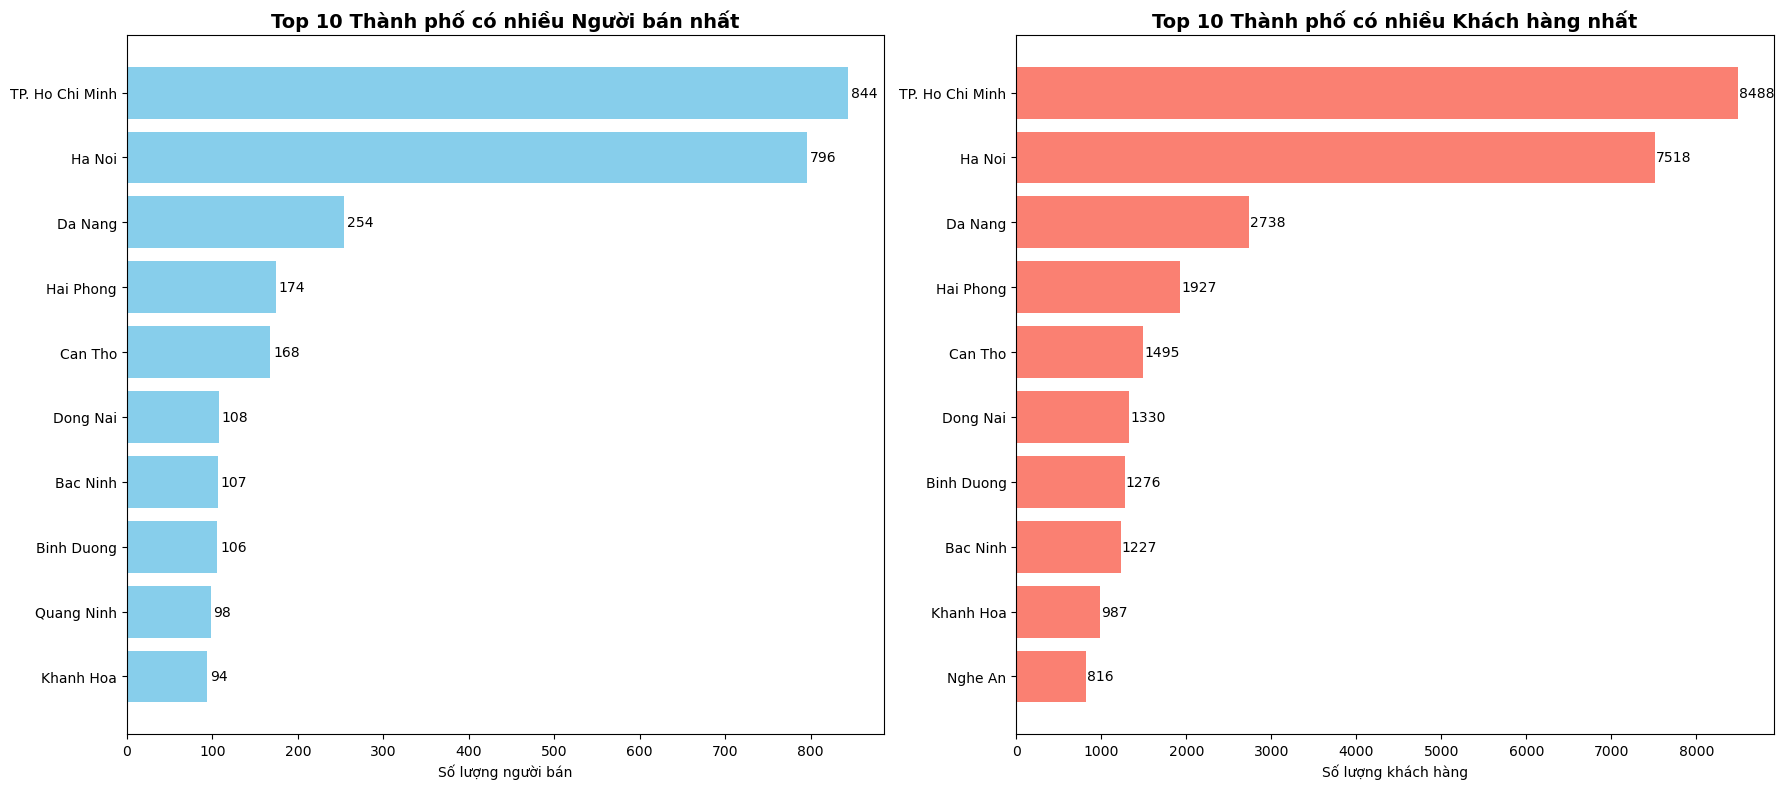

In [ ]:
# Điều tra xem đa phần người mua sẽ ở đâu và đa phần người bán sẽ ở đâu
# Lấy các thành phố của người bán (Sellers)
sellers_city = ecommerce_data['sellers'].groupby("seller_city").size().reset_index().rename(columns = {0: "total_sellers"})
# Lấy các thành phố của người mua (Customers)
customers_city = ecommerce_data['customers'].groupby("customer_city").size().reset_index().rename(columns = {0: "total_customers"})

sellers_city = sellers_city.sort_values("total_sellers", ascending=False).head(10)
customers_city = customers_city.sort_values("total_customers", ascending=False).head(10)

# Vẽ biểu đồ
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
# Biểu đồ 1: Sellers
sellers_city = sellers_city.sort_values("total_sellers", ascending=True)
ax[0].barh(sellers_city['seller_city'], sellers_city['total_sellers'], color='skyblue')
ax[0].set_title('Top 10 Thành phố có nhiều Người bán nhất', fontsize=14, fontweight='bold')
ax[0].set_xlabel('Số lượng người bán')
# Thêm nhãn giá trị
for i, v in enumerate(sellers_city['total_sellers']):
    ax[0].text(v + 3, i, str(v), color='black', va='center')
# Biểu đồ 2: Customers
customers_city = customers_city.sort_values("total_customers", ascending=True)
ax[1].barh(customers_city['customer_city'], customers_city['total_customers'], color='salmon')
ax[1].set_title('Top 10 Thành phố có nhiều Khách hàng nhất', fontsize=14, fontweight='bold')
ax[1].set_xlabel('Số lượng khách hàng')
# Thêm nhãn giá trị
for i, v in enumerate(customers_city['total_customers']):
    ax[1].text(v + 10, i, str(v), color='black', va='center')

plt.tight_layout()
plt.show()

Tạo biến thể hiện quãng đường vận chuyển từ chỗ người bán đến chỗ người mua cho từng đơn hàng.

Sử dụng công thức Haversine tính đường chim bay (đường thẳng) sau đó nhân với hệ số đường cong (dùng trong Logistic)

In [ ]:
# Định nghĩa hàm tính Haversine Vectorized
def calculate_haversine_vectorized(lat1, lon1, lat2, lon2):
    """
    Tính khoảng cách Haversine giữa các cặp tọa độ.
    """
    R = 6371.0  # Bán kính trái đất (km)
    # Chuyển đổi độ sang radian
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda / 2)**2
    # Xử lý sai số dấu phẩy động
    a = np.clip(a, 0, 1)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# Áp dụng tính toán trực tiếp
# Tính khoảng cách thô ("đường chim bay")
clean_data['distance_km'] = calculate_haversine_vectorized(
    clean_data['customer_lat'], clean_data['customer_lng'],
    clean_data['seller_lat'], clean_data['seller_lng']
)

# Áp dụng hệ số điều chỉnh (Factor Logic)
# Nếu <= 30km (nội thành/lân cận) nhân 1.5, ngược lại (liên tỉnh) nhân 1.35
# Hệ số này mô phỏng quãng đường thực tế luôn dài hơn đường chim bay
factor = np.where(clean_data['distance_km'] <= 30, 1.5, 1.35)
# Tính kết quả cuối cùng và làm tròn
clean_data['distance_km'] = (clean_data['distance_km'] * factor).round(2)

# Xóa các cột tọa độ để làm gọn bảng dữ liệu
clean_data = clean_data.drop(columns=['customer_lat', 'customer_lng', 'seller_lat', 'seller_lng'])
display(clean_data.head())

StatementMeta(, 70b6eae9-aaeb-442b-94e4-6cfce5628bb2, 30, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 71ca4075-4cfb-477e-8340-194f90b2a403)

In [ ]:
display(clean_data.head(20))

StatementMeta(, 70b6eae9-aaeb-442b-94e4-6cfce5628bb2, 31, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, f91b6f87-a16b-413d-b786-e1b59d96fc4a)

# 3. Phân tích mô tả

## Phân tích thống kê các trường dữ liệu số

In [ ]:
def stats(df):
    stat_dict = {
        # Đếm số dòng
        'Count': df.count(),
        # Tìm giá trị nhỏ nhất
        'Min': df.min(),
        # Tìm giá trị lớn nhất
        'Max': df.max(),
        # Tìm giá trị trung bình
        'Average': df.mean(),
        # Tìm giá trị median
        'Median': df.median(),
        # Tìm giá trị mode
        'Mode': df.mode().iloc[0],
        # Tìm giá trị Q1, Q2, Q3
        'Q1': df.quantile(0.25),
        'Q2': df.quantile(0.5),
        'Q3': df.quantile(0.75),
        # IQR
        'IQR': df.quantile(0.75) - df.quantile(0.25),
        # Variance
        'Var': df.var(),
        # STDEV
        'Stdev': df.std()
    }

    stat_df = pd.DataFrame(stat_dict).T.reset_index()
    return stat_df

StatementMeta(, 70b6eae9-aaeb-442b-94e4-6cfce5628bb2, 32, Finished, Available, Finished)

In [ ]:
numeric_df = clean_data.select_dtypes(include='number')
display(stats(numeric_df))

StatementMeta(, 70b6eae9-aaeb-442b-94e4-6cfce5628bb2, 33, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, a121f42e-7ec8-41e8-a211-ce341e4c44d6)

### 1. Phân tích Giá trị đơn hàng & Doanh thu (`price` & `freight_value`)

Dữ liệu cho thấy sự chênh lệch rất lớn về giá trị hàng hóa:

  * **Giá sản phẩm (`price`):**

      * **Biến động cực lớn:** Giá trải dài từ **20,000** (Min) đến gần **80 triệu** (Max: 79,998,000).
      * **Phân phối lệch phải:** Giá trung bình (**Average**: \~11.7 triệu) cao hơn rất nhiều so với trung vị (**Median**: \~2.1 triệu). Điều này cho thấy có một lượng nhỏ các đơn hàng giá trị "khủng" đang kéo mức trung bình lên, trong khi **50% số đơn hàng có giá trị dưới 2.1 triệu**.
      * **Phổ biến nhất (Mode):** Mức giá xuất hiện nhiều nhất chỉ là **110,000**, cho thấy các sản phẩm giá rẻ chiếm số lượng áp đảo về tần suất giao dịch.

  * **Phí vận chuyển (`freight_value`):**

      * Phí ship trung bình khoảng **1.47 triệu**. Đây là con số khá cao, nhưng cần lưu ý Min chỉ 1,000 và Max lên tới gần **16 triệu**.
      * Khoảng biến thiên phí ship (IQR) từ 71,000 (Q1) đến 1.77 triệu (Q3).
      * **Nhận xét:** Phí vận chuyển cao đột biến ở một số đơn hàng có thể do vận chuyển các mặt hàng cồng kềnh (liên quan đến trọng lượng/kích thước phân tích ở dưới) hoặc khoảng cách quá xa.

### 2. Phân tích Vận hành & Logistics

  * **Thời gian giao hàng (`delivery_time`):**

      * **Tốc độ giao hàng:** Trung bình mất khoảng **7 ngày** (Average: 7.03) để giao hàng.
      * **Ổn định:** 50% đơn hàng được giao trong vòng khoảng 6.9 ngày (Median).
      * **Ngoại lệ:** Thời gian giao nhanh nhất là 0 ngày (giao trong ngày), nhưng chậm nhất lên tới **20 ngày**. Độ lệch chuẩn (Stdev) là 3.5 ngày, cho thấy quy trình giao hàng tương đối ổn định, ít có sự cố quá nghiêm trọng kéo dài hàng tháng trời.

  * **Khoảng cách vận chuyển (`distance_km`):**

      * **Khoảng cách trung bình:** Khoảng **789 km**.
      * **Phân cực:** Có những đơn hàng khoảng cách bằng 0 (người mua và bán ở cùng khu vực/zipcode) nhưng có đơn lên tới **1,711 km**.
      * **Mode = 0:** Rất nhiều đơn hàng (phổ biến nhất) là giao dịch nội vùng/gần nhau.

### 3. Phân tích Đặc điểm sản phẩm (`product_weight_g`, `length`, `height`, `width`)

  * **Trọng lượng:**
      * Trung bình sản phẩm nặng khoảng **2.5 kg** (2,514g).
      * Tuy nhiên, Max lên tới gần **5 kg** (4,999g - có thể dữ liệu đã bị lọc hoặc giới hạn ở mức 5kg, hoặc đây là một tập con của dữ liệu lớn hơn vì hàng nội thất thường nặng hơn nhiều).
  * **Kích thước:**
      * Sản phẩm trung bình có kích thước khoảng **54 x 54 x 27 cm**.
      * Sản phẩm lớn nhất có chiều dài/rộng lên tới gần 1 mét (99cm).


In [ ]:
# Có thể nhận thấy có 1 số đơn hàng có ngày giao hàng=0, điều này làm dấy lên nghi ngờ về những đơn hàng có quãng đường và thời gian vận chuyển bất hợp lí
test_data = clean_data.copy()
no_delivery_time = test_data[test_data['delivery_time']==0]
print(f"Có {no_delivery_time.shape[0]} đơn hàng có ngày giao hàng bằng 0, chiếm {(no_delivery_time.shape[0]/test_data.shape[0])*100}%")
display(no_delivery_time)
test_data['velocity'] = test_data['distance_km'] / ((test_data['delivery_time']*24)+0.01) # Tránh việc chia cho 0, vì có những đơn hàng thời gian giao hàng=0

# Lọc các đơn hàng "Siêu thanh" (Supersonic Delivery)
# Ngưỡng: > 100km/h (Tốc độ này xe tải không chạy được, máy bay thì có thể nhưng cần xem xét thời gian first-mile/last-mile)
# Đồng thời lọc khoảng cách > 50km để tránh sai số ở các đơn nội thành
suspicious_orders = test_data[
    (test_data['velocity'] > 100) &
    (test_data['distance_km'] > 50)
].copy()
# Sắp xếp theo tốc độ giảm dần để xem cái nào vô lý nhất
suspicious_orders = suspicious_orders.sort_values(by='velocity', ascending=False)
# 4. Hiển thị kết quả
print(f"Tìm thấy {suspicious_orders.shape[0]} đơn hàng có tốc độ nhanh bất thường (>100km/h), chiếm tỷ lệ: {(suspicious_orders.shape[0]/test_data.shape[0])*100}%:")
display(suspicious_orders)


StatementMeta(, 70b6eae9-aaeb-442b-94e4-6cfce5628bb2, 34, Finished, Available, Finished)

Có 15 đơn hàng có ngày giao hàng bằng 0, chiếm 0.0009051035166892038%


SynapseWidget(Synapse.DataFrame, 1da86672-379a-4249-84ca-97dcab290d98)

Tìm thấy 1308 đơn hàng có tốc độ nhanh bất thường (>100km/h), chiếm tỷ lệ: 0.07892502665529856%:


SynapseWidget(Synapse.DataFrame, c39a137c-d43e-4b5a-ba56-efdb7f6711e8)

Có thể thấy có một phần tỷ lệ rất nhỏ các đơn hàng có thời gian giao hàng bằng 0 và có thời gian giao hàng cùng quãng đường giao hàng bất hợp lí với nhau. Tuy nhiên, cho tỷ lệ của các trường hợp này rất nhỏ (chưa đến 1%) nên nhóm quyết định xóa.

In [ ]:
clean_data = clean_data[clean_data['delivery_time']!=0]
clean_data['velocity'] = clean_data['distance_km'] / ((clean_data['delivery_time']*24)+0.01) # Tránh việc chia cho 0, vì có những đơn hàng thời gian giao hàng=0
condition = (clean_data['velocity'] <= 100) | (clean_data['distance_km'] <= 50)
clean_data = clean_data[condition]
clean_data = clean_data.drop(columns = ['velocity'])
display(stats(clean_data.select_dtypes(include='number')))

StatementMeta(, 70b6eae9-aaeb-442b-94e4-6cfce5628bb2, 35, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, bf767d2b-fc9d-4a7b-a5a4-b25a60bbefdc)

In [ ]:
# Kiểm tra các đơn hàng có thời gian giao hàng <1 (dưới 1 ngày)
checking_condition = (clean_data['delivery_time']<1 & (clean_data['customer_city']!=clean_data['seller_city'])) | (clean_data['delivery_time']<0.02)
too_fast_delivery = clean_data[checking_condition].copy()
print(f"Có {len(too_fast_delivery)} số đơn hàng liên tỉnh có thời gian giao hàng dưới 1 ngày, chiếm {(len(too_fast_delivery)/len(clean_data))*100}%")
display(too_fast_delivery)

StatementMeta(, 70b6eae9-aaeb-442b-94e4-6cfce5628bb2, 36, Finished, Available, Finished)

Có 3776 số đơn hàng liên tỉnh có thời gian giao hàng dưới 1 ngày, chiếm 0.22802510691696287%


SynapseWidget(Synapse.DataFrame, a7d1d20d-c7c1-49c9-ba44-44888c892e21)

Nhận thấy vẫn tồn tại 1 số đơn hàng liên tỉnh nhưng thời gian giao hàng chưa đến 1 ngày, điều này là bất hợp lí. Đồng thời, có những đơn hàng tuy là cùng tỉnh, nhưng thời gian giao hàng quá ngắn (0.01 ngày tương đương với 15p giao hàng) cũng sẽ bị loại bỏ.

In [ ]:
clean_data = clean_data[~checking_condition]
display(stats(clean_data.select_dtypes(include='number')))

StatementMeta(, 70b6eae9-aaeb-442b-94e4-6cfce5628bb2, 37, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, b8a26d2b-8db9-4365-8d06-5db0023b18c1)

## Phân tích thống kê các trường dữ liệu khác

In [ ]:
# Lấy bảng thống kê cơ bản
cat_summary = clean_data.describe(exclude = ['number']).transpose()

# Tính thêm cột % của giá trị Top
cat_summary['top_percent'] = (cat_summary['freq'] / cat_summary['count']) * 100

# Sắp xếp theo mức độ phổ biến
display(cat_summary.sort_values('unique').reset_index())

StatementMeta(, 70b6eae9-aaeb-442b-94e4-6cfce5628bb2, 38, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 696d63c0-aaf5-4d4e-b06e-13c98a2b5c6e)

### 1. Thống kê

  * **Kích thước:** Bộ dữ liệu có khoảng **1.65 triệu dòng** (chính xác là 1,652,482).
      * *Lưu ý:* Số lượng `order_id` duy nhất là **826,892**. Tức là trung bình mỗi đơn hàng có khoảng **2 sản phẩm** (items).
  * **Độ phủ dữ liệu:** Cột `count` đều bằng nhau ở tất cả các trường (1,652,482).

### 2. Phân tích Khách hàng & Người bán (Địa lý)

  * **Thành phố chủ đạo:**
      * Cả người mua (`customer_city`) và người bán (`seller_city`) đều tập trung đông nhất ở **TP. Ho Chi Minh**.
      * Tỷ lệ áp đảo: Người mua ở HCM chiếm ~40%, Người bán ở HCM chiếm ~40.5%.
### 3. Phân tích Đơn hàng & Sản phẩm

  * **Trạng thái đơn hàng:**
      * `top` = **delivered** (Đã giao hàng).
      * Tỷ lệ thành công (`top_percent`) lên tới **96.6%**.
      * *Insight:* Tỷ lệ hủy/hoàn trả chỉ chiếm khoảng 3.4%. Đây là tỷ lệ rất lý tưởng.
  * **Danh mục sản phẩm:**
      * Có **11 nhóm ngành hàng** (`unique` = 11).
      * Nhóm bán chạy nhất: (Đồ chơi & Mẹ bé), chiếm khoảng **9.4%**.
      * *Insight:* Ngành hàng này thường là các món đồ nhỏ nhẹ, dễ vận chuyển, phù hợp với chiến lược Free Ship.

### 4. Phân tích Thời gian (Timestamp)
  * Dữ liệu bao gồm lịch sử giao dịch trong khoảng **5-6 năm**.


## Phân tích đơn biến

Để phân tích thời gian giao hàng và các yếu tố ảnh hưởng đến thời gian giao hàng, cần lọc các đơn hàng được giao hàng thành công.

In [ ]:
delivered_data = clean_data[clean_data['order_status']=='delivered'].copy()
display(delivered_data)

StatementMeta(, 70b6eae9-aaeb-442b-94e4-6cfce5628bb2, 39, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 6beaad9e-3bff-4fe5-ab07-636421126006)

StatementMeta(, 70b6eae9-aaeb-442b-94e4-6cfce5628bb2, 40, Finished, Available, Finished)

/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


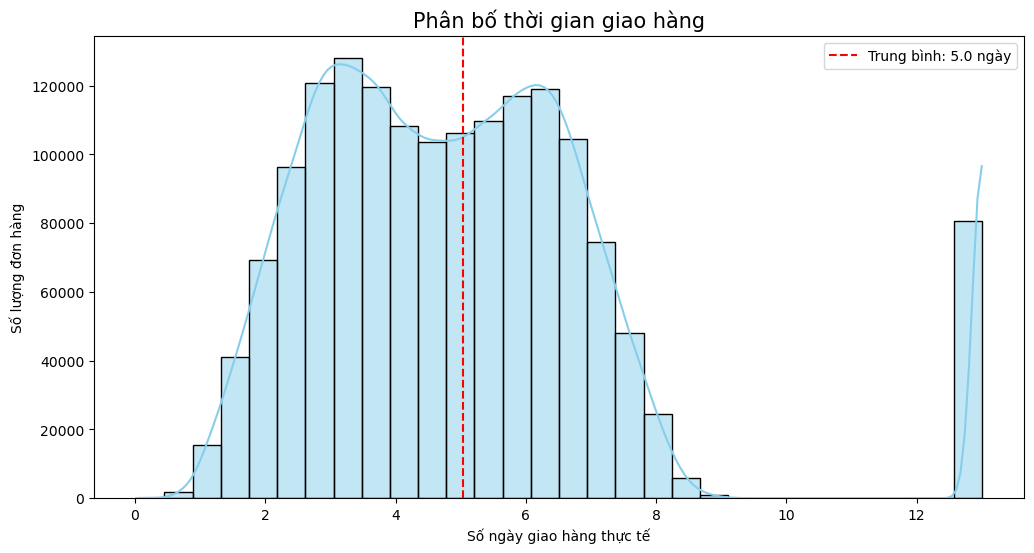

In [ ]:
# Phân tích phân phối của biến mục tiêu
plt.figure(figsize=(12, 6))
sns.histplot(data=delivered_data, x='delivery_time', kde=True, bins=30, color='skyblue')

plt.title('Phân bố thời gian giao hàng', fontsize=15)
plt.xlabel('Số ngày giao hàng thực tế')
plt.ylabel('Số lượng đơn hàng')
plt.axvline(delivered_data['delivery_time'].mean(), color='red', linestyle='--', label=f"Trung bình: {delivered_data['delivery_time'].mean():.1f} ngày")
plt.legend()
plt.show()

### 1. Thời gian giao hàng nhanh
* **Mean:** Trung bình **5.0 ngày**.
* **Phân phối tập trung:** Dữ liệu dồn phần lớn vào khoảng **1 - 8 ngày**. Điều này cho thấy quy trình vận hành đã loại bỏ được các yếu tố gây nhiễu kéo dài.

### 2. Dấu hiệu lạ: Phân phối "Hai đỉnh" (Bimodal Distribution)
* **Đỉnh 1 (khoảng 3 ngày):** Đại diện cho nhóm giao nhanh (có thể là nội thành hoặc giao hỏa tốc).
* **Đỉnh 2 (khoảng 6-7 ngày):** Đại diện cho nhóm giao chậm (liên tỉnh hoặc vận chuyển đường bộ).
* **Insight:** Nó cho thấy dữ liệu bắt đầu phân tách được các nhóm vận chuyển khác nhau.

### 3. Vấn đề kỹ thuật: Cột đột biến ở ngày 13 (Capping/Clipping)
Cao vọt lên một cách bất thường, tách biệt hẳn với đường cong phân phối.

In [ ]:
# Kiểm tra những dòng có ngày giao hàng là 13
deliver_day_13 = delivered_data[delivered_data['delivery_time']>=13]
display(deliver_day_13)
print(f"Có {len(deliver_day_13)} dòng có ngày giao hàng bằng 13, chiếm {(len(deliver_day_13)/len(delivered_data))*100}%")

StatementMeta(, 70b6eae9-aaeb-442b-94e4-6cfce5628bb2, 41, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, b93c3294-e328-4441-a049-f4572d2b070c)

Có 80693 dòng có ngày giao hàng bằng 13, chiếm 5.05668110065987%


In [ ]:
# Điều tra mối quan hệ giữa cột `order_delivered_customer_date` với các cột khác
time_col = deliver_day_13.drop(columns = ['order_delivered_customer_date']).select_dtypes(include='datetime').columns
for col in time_col:
    print(f"Trung bình sai khác giữa cột `order_delivered_customer_date` và `{col}`: là {((deliver_day_13['order_delivered_customer_date'] - deliver_day_13[col]).dt.total_seconds()).mean()}")

StatementMeta(, 70b6eae9-aaeb-442b-94e4-6cfce5628bb2, 42, Finished, Available, Finished)

Trung bình sai khác giữa cột `order_delivered_customer_date` và `shipping_limit_date`: là 864000.0
Trung bình sai khác giữa cột `order_delivered_customer_date` và `order_purchase_timestamp`: là 1123200.0
Trung bình sai khác giữa cột `order_delivered_customer_date` và `order_approved_at`: là 561746.153941482
Trung bình sai khác giữa cột `order_delivered_customer_date` và `order_delivered_carrier_date`: là 864000.0
Trung bình sai khác giữa cột `order_delivered_customer_date` và `order_estimated_delivery_date`: là 0.0


Từ phân tích này, có thể giả định rằng số ngày 13 bất thường kia thuộc về chính sách của công ty. Công ty ước tính số ngày giao hàng tối đa là 13 ngày và đây là những đơn hàng mà có thể shipper đã giao hàng nhưng chưa ấn xác nhận nên sẽ ghi nhận ngày nhận hàng là ngày dự kiến nhận hàng. Điều này là hoàn toàn bình thường tuy nhiên việc giữ lại các đơn hàng đó là không cần thiết vì chúng sẽ không cung cấp thông tin gì về thời gian vận chuyển và các yếu tố ảnh hưởng đến nó. Chính vì vậy, nhóm quyết định loại bỏ nó.

StatementMeta(, 70b6eae9-aaeb-442b-94e4-6cfce5628bb2, 43, Finished, Available, Finished)

/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


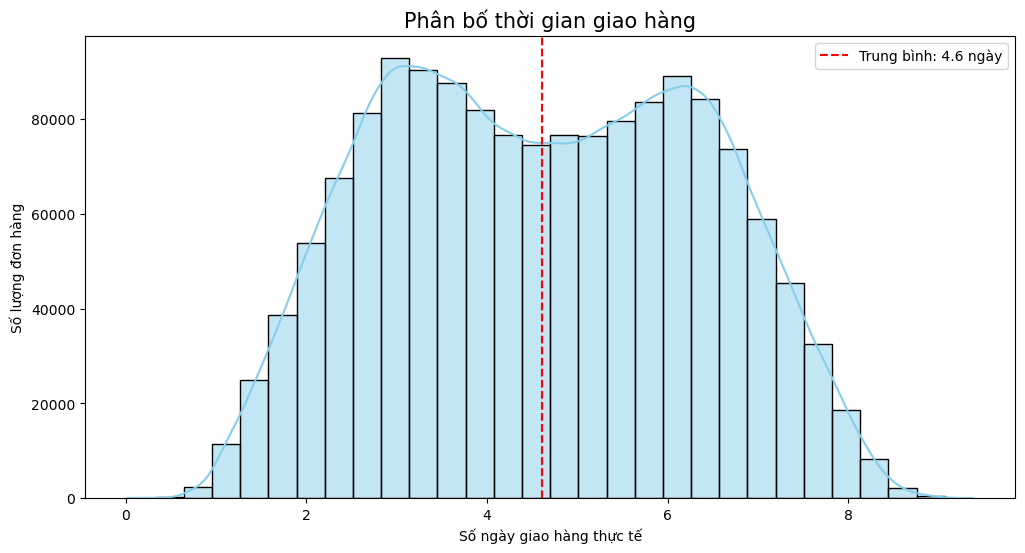

In [ ]:
delivered_data = delivered_data[delivered_data['delivery_time']<13]
# Phân tích phân phối của biến mục tiêu
plt.figure(figsize=(12, 6))
sns.histplot(data=delivered_data, x='delivery_time', kde=True, bins=30, color='skyblue')

plt.title('Phân bố thời gian giao hàng', fontsize=15)
plt.xlabel('Số ngày giao hàng thực tế')
plt.ylabel('Số lượng đơn hàng')
plt.axvline(delivered_data['delivery_time'].mean(), color='red', linestyle='--', label=f"Trung bình: {delivered_data['delivery_time'].mean():.1f} ngày")
plt.legend()
plt.show()

## Phân tích đa biến

### Phân tích mối quan hệ giữa khoảng cách và thời gian giao hàng

StatementMeta(, 70b6eae9-aaeb-442b-94e4-6cfce5628bb2, 44, Finished, Available, Finished)

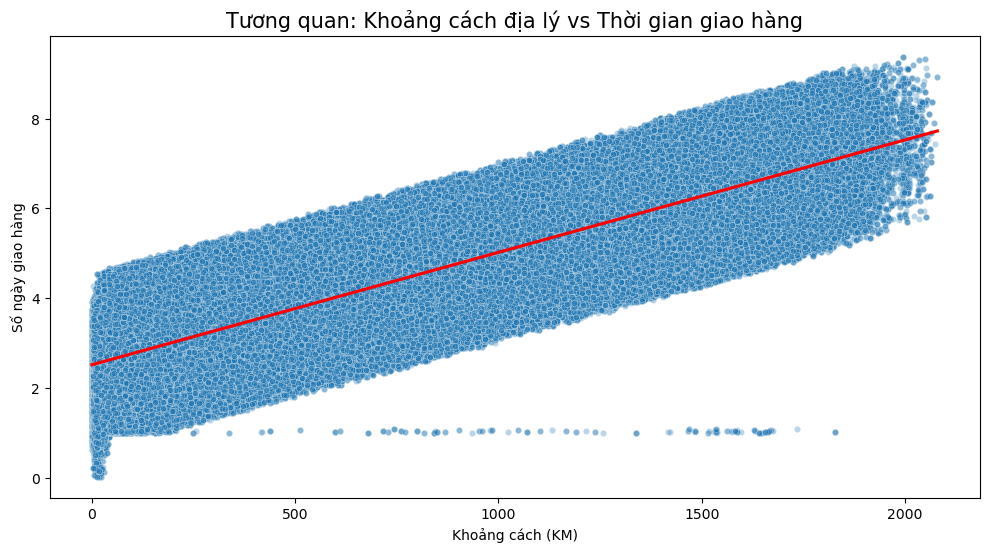

Hệ số tương quan giữa Khoảng cách và Thời gian: 0.8855


In [ ]:
# Vẽ biểu đồ Scatter Plot (Biểu đồ tản)
plt.figure(figsize=(12, 6))
sns.scatterplot(data=delivered_data, x='distance_km', y='delivery_time', alpha=0.3, s=20)

# Vẽ đường xu hướng (Trend line)
sns.regplot(data=delivered_data, x='distance_km', y='delivery_time', scatter=False, color='red')

plt.title('Tương quan: Khoảng cách địa lý vs Thời gian giao hàng', fontsize=15)
plt.xlabel('Khoảng cách (KM)')
plt.ylabel('Số ngày giao hàng')
plt.show()

# Tính hệ số tương quan (Correlation)
corr = delivered_data['distance_km'].corr(delivered_data['delivery_time'])
print(f"Hệ số tương quan giữa Khoảng cách và Thời gian: {corr:.4f}")

### Tương quan tuyến tính mạnh mẽ (Strong Positive Linear Correlation)
* **Hệ số $R \approx 0.89$:** Đây là một con số **cực kỳ cao**.
* **Ý nghĩa:** Biểu đồ khẳng định một chân lý trong Logistics mà biểu đồ cũ đã phủ nhận: **"Càng xa thì giao càng lâu"**. Giờ đây, khoảng cách địa lý là biến số quan trọng nhất (Predictor) để dự báo thời gian giao hàng.

StatementMeta(, 70b6eae9-aaeb-442b-94e4-6cfce5628bb2, 45, Finished, Available, Finished)

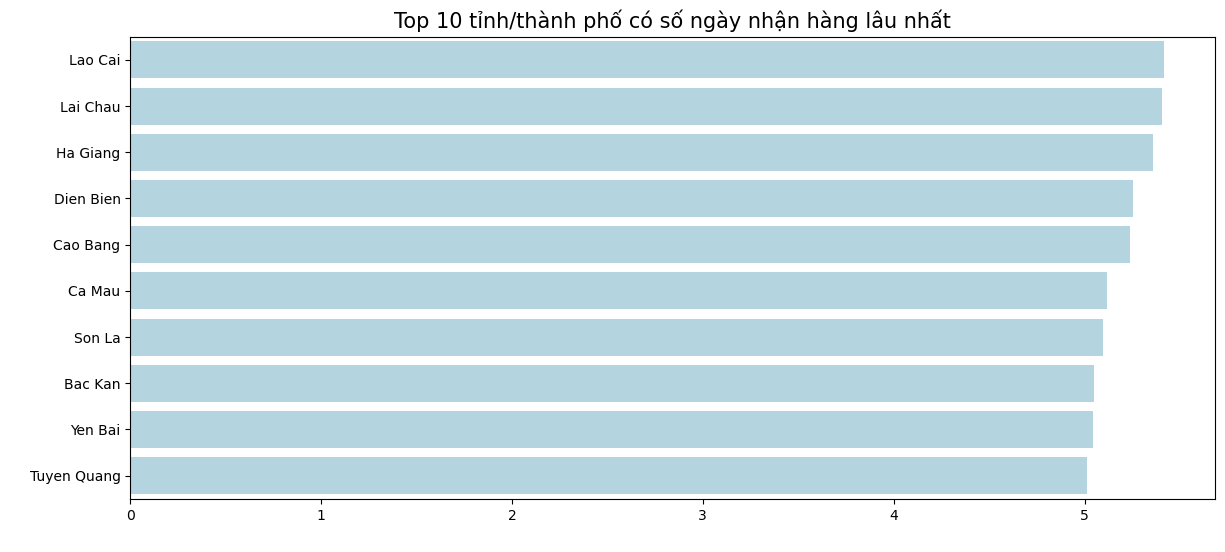

In [ ]:
customers_city_deliveried = delivered_data.groupby('customer_city').agg({
    'delivery_time': 'mean'
}).reset_index().rename(columns = {'delivery_time':'avg_days'})

customers_city_deliveried = customers_city_deliveried.sort_values(by='avg_days', ascending=False)

# 2. Vẽ biểu đồ cột (Bar Chart)
plt.figure(figsize=(14, 6))
sns.barplot(data=customers_city_deliveried.head(10), x='avg_days', y='customer_city', color = 'lightblue')

plt.title('Top 10 tỉnh/thành phố có số ngày nhận hàng lâu nhất', fontsize=15)
plt.xlabel(' ')
plt.ylabel(' ')
plt.show()

StatementMeta(, 70b6eae9-aaeb-442b-94e4-6cfce5628bb2, 46, Finished, Available, Finished)

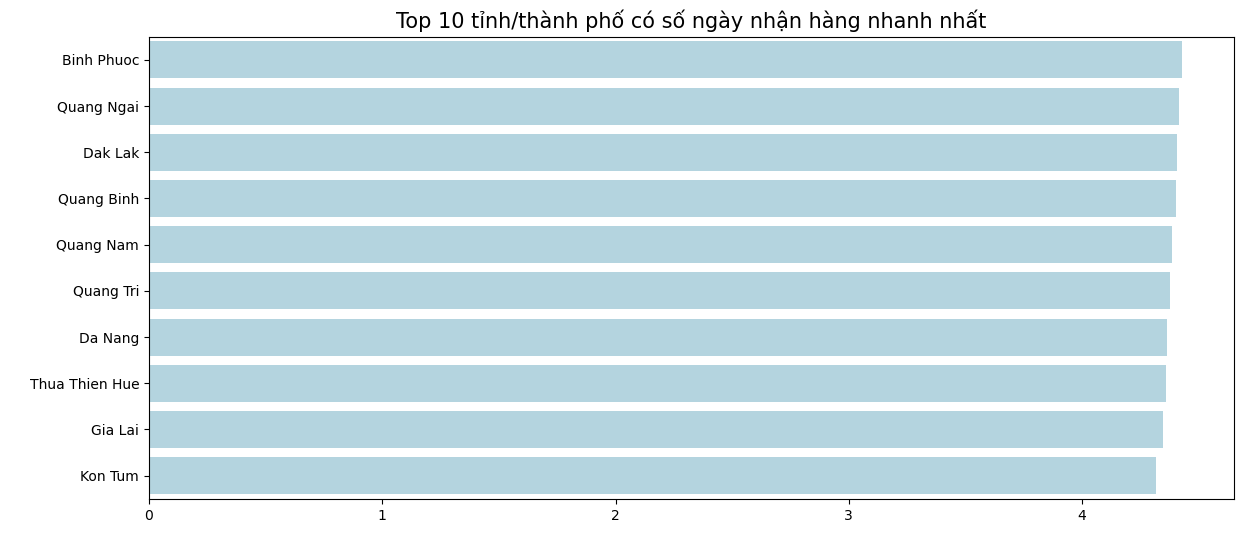

In [ ]:
plt.figure(figsize=(14, 6))
sns.barplot(data=customers_city_deliveried.tail(10), x='avg_days', y='customer_city', color = 'lightblue')

plt.title('Top 10 tỉnh/thành phố có số ngày nhận hàng nhanh nhất', fontsize=15)
plt.xlabel(' ')
plt.ylabel(' ')
plt.show()

StatementMeta(, 70b6eae9-aaeb-442b-94e4-6cfce5628bb2, 47, Finished, Available, Finished)

Thống kê thời gian giao hàng:
                count      mean   50%       std
route_type                                     
Liên tỉnh   1417831.0  4.771735  4.78  1.690492
Nội thành     97246.0  2.310321  2.31  0.724869


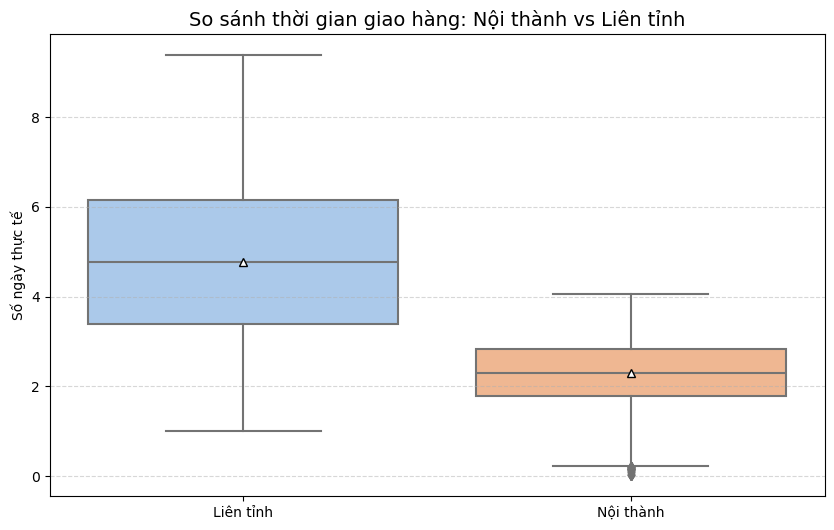

In [ ]:
# So sánh số ngày nhận hàng giữa nội thành và liên tỉnh
delivered_data['route_type'] = np.where(
    delivered_data['customer_city'] == delivered_data['seller_city'],
    'Nội thành',
    'Liên tỉnh'
)
# Để xem sự chênh lệch về trung bình (mean) và trung vị (50%)
print("Thống kê thời gian giao hàng:")
print(delivered_data.groupby('route_type')['delivery_time'].describe()[['count', 'mean', '50%', 'std']])

# Trực quan hóa bằng Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=delivered_data,
    x='route_type',
    y='delivery_time',
    palette=['#a1c9f4', '#ffb482'], # Màu xanh nhẹ vs cam nhẹ
    showmeans=True, # Hiển thị thêm dấu tam giác thể hiện giá trị trung bình
    meanprops={"marker":"^", "markerfacecolor":"white", "markeredgecolor":"black"}
)

plt.title('So sánh thời gian giao hàng: Nội thành vs Liên tỉnh', fontsize=14)
plt.ylabel('Số ngày thực tế')
plt.xlabel('')
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

StatementMeta(, 70b6eae9-aaeb-442b-94e4-6cfce5628bb2, 48, Finished, Available, Finished)

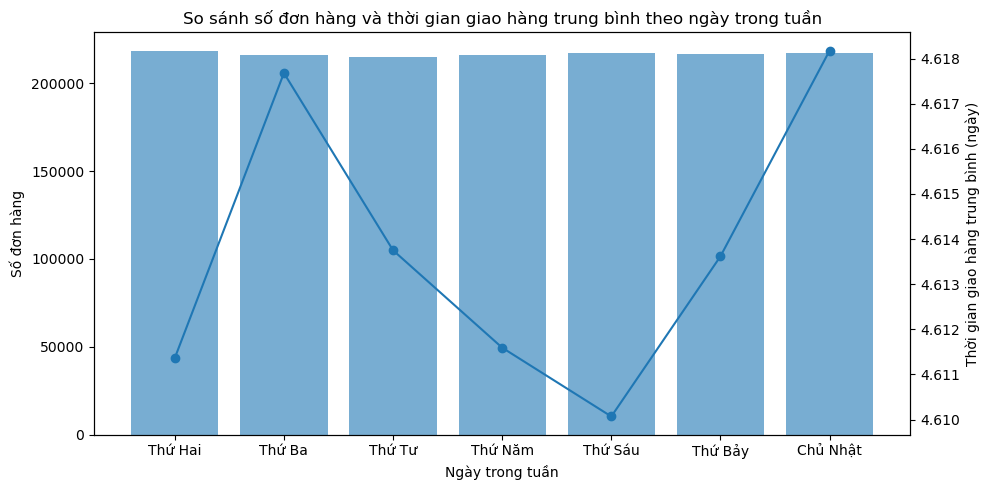

In [ ]:
# So sánh số đơn hàng và thời gian giao hàng trung bình những ngày đặt hàng trong tuần
# Tạo cột ngày trong tuần
delivered_data['purchase_dow'] = pd.to_datetime(
    delivered_data["order_purchase_timestamp"]
).dt.dayofweek.map({
    0: "Thứ Hai", 1: "Thứ Ba", 2: "Thứ Tư",
    3: "Thứ Năm", 4: "Thứ Sáu", 5: "Thứ Bảy", 6: "Chủ Nhật"
})
dow_order = [
    "Thứ Hai", "Thứ Ba", "Thứ Tư",
    "Thứ Năm", "Thứ Sáu", "Thứ Bảy", "Chủ Nhật"
]
# Số đơn hàng theo ngày
order_count = (
    delivered_data
    .groupby("purchase_dow")
    .size()
    .reindex(dow_order)
)
# Thời gian giao hàng trung bình theo ngày
avg_delivery = (
    delivered_data
    .groupby("purchase_dow")["delivery_time"]
    .mean()
    .reindex(dow_order)
)

# Vẽ biểu đồ kết hợp
fig, ax1 = plt.subplots(figsize=(10, 5))
# Bar chart số đơn hàng
ax1.bar(order_count.index, order_count.values, alpha=0.6)
ax1.set_ylabel("Số đơn hàng")
ax1.set_xlabel("Ngày trong tuần")
# Line chart thời gian giao hàng trung bình
ax2 = ax1.twinx()
ax2.plot(avg_delivery.index, avg_delivery.values, marker="o")
ax2.set_ylabel("Thời gian giao hàng trung bình (ngày)")
# Title
plt.title("So sánh số đơn hàng và thời gian giao hàng trung bình theo ngày trong tuần")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


StatementMeta(, 70b6eae9-aaeb-442b-94e4-6cfce5628bb2, 49, Finished, Available, Finished)

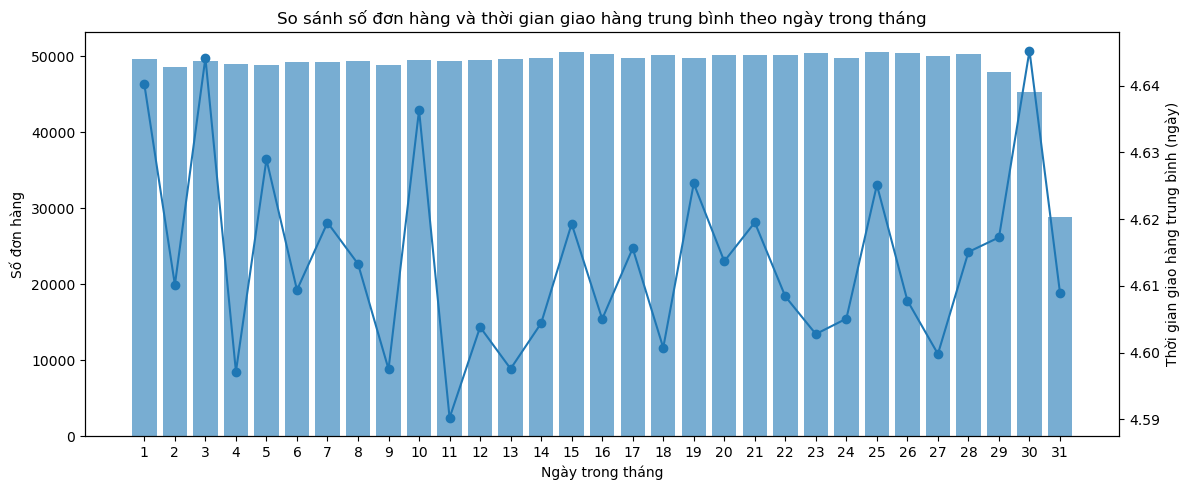

In [ ]:
# So sánh số đơn hàng và thời gian giao hàng những ngày đặt hàng trong tháng
# Tạo cột ngày trong tháng
delivered_data["purchase_dom"] = pd.to_datetime(
    delivered_data["order_purchase_timestamp"]
).dt.day
# Thứ tự ngày trong tháng
dom_order = list(range(1, 32))
# Số đơn hàng theo ngày trong tháng
order_count = (
    delivered_data
    .groupby("purchase_dom")
    .size()
    .reindex(dom_order)
)
# Thời gian giao hàng trung bình theo ngày trong tháng
avg_delivery = (
    delivered_data
    .groupby("purchase_dom")["delivery_time"]
    .mean()
    .reindex(dom_order)
)

# Vẽ biểu đồ kết hợp
fig, ax1 = plt.subplots(figsize=(12, 5))
# Bar chart số đơn hàng
ax1.bar(order_count.index, order_count.values, alpha=0.6)
ax1.set_xlabel("Ngày trong tháng")
ax1.set_ylabel("Số đơn hàng")
# Line chart thời gian giao hàng trung bình
ax2 = ax1.twinx()
ax2.plot(avg_delivery.index, avg_delivery.values, marker="o")
ax2.set_ylabel("Thời gian giao hàng trung bình (ngày)")
# Title
plt.title("So sánh số đơn hàng và thời gian giao hàng trung bình theo ngày trong tháng")
plt.xticks(dom_order)
plt.tight_layout()
plt.show()

StatementMeta(, 70b6eae9-aaeb-442b-94e4-6cfce5628bb2, 50, Finished, Available, Finished)

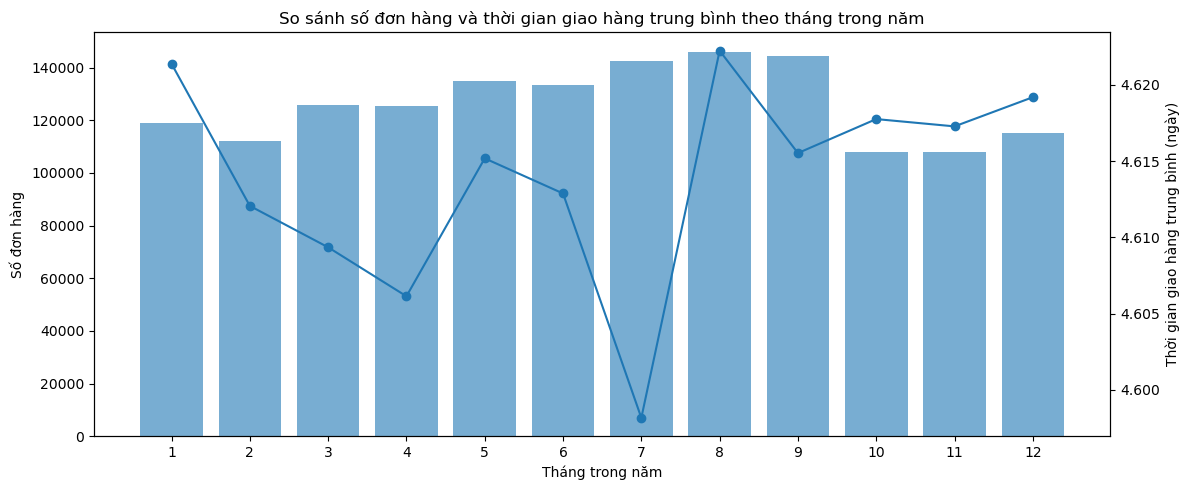

In [ ]:
# So sánh số đơn hàng và thời gian giao hàng theo tháng đặt hàng trong năm
# Tạo cột tháng trong năm
delivered_data["purchase_month"] = pd.to_datetime(
    delivered_data["order_purchase_timestamp"]
).dt.month
# Thứ tự tháng
month_order = list(range(1, 13))
# Số đơn hàng theo tháng
order_count = (
    delivered_data
    .groupby("purchase_month")
    .size()
    .reindex(month_order)
)
# Thời gian giao hàng trung bình theo tháng
avg_delivery = (
    delivered_data
    .groupby("purchase_month")["delivery_time"]
    .mean()
    .reindex(month_order)
)

# Vẽ biểu đồ kết hợp
fig, ax1 = plt.subplots(figsize=(12, 5))
# Bar chart số đơn hàng
ax1.bar(order_count.index, order_count.values, alpha=0.6)
ax1.set_xlabel("Tháng trong năm")
ax1.set_ylabel("Số đơn hàng")
# Line chart thời gian giao hàng trung bình
ax2 = ax1.twinx()
ax2.plot(avg_delivery.index, avg_delivery.values, marker="o")
ax2.set_ylabel("Thời gian giao hàng trung bình (ngày)")

# Title
plt.title("So sánh số đơn hàng và thời gian giao hàng trung bình theo tháng trong năm")
plt.xticks(month_order)
plt.tight_layout()
plt.show()


StatementMeta(, 70b6eae9-aaeb-442b-94e4-6cfce5628bb2, 51, Finished, Available, Finished)

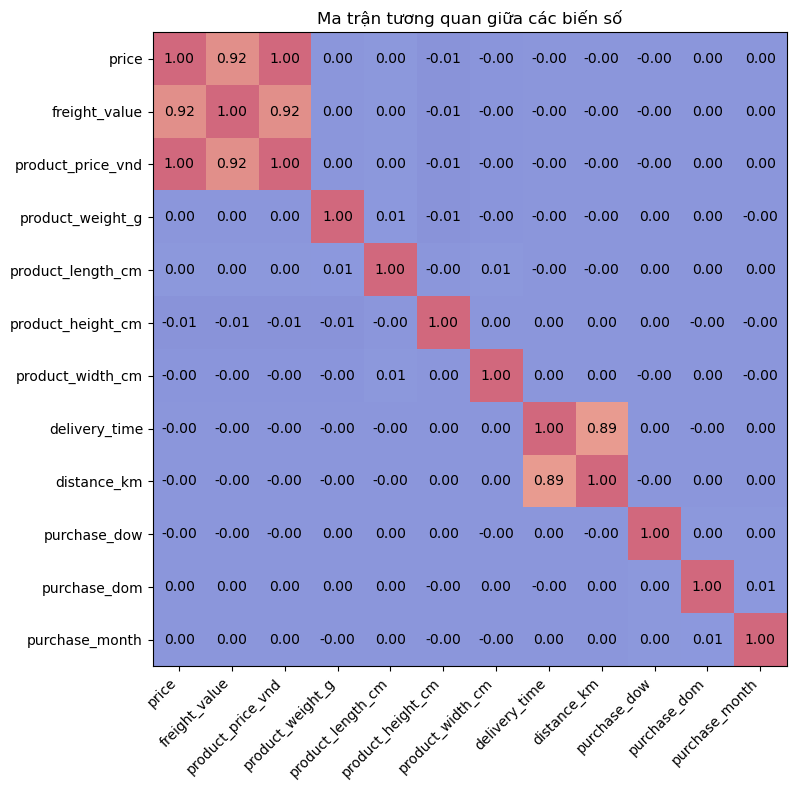

In [ ]:
# Xác định mối tương quan giữa các biến số
delivered_data['purchase_dow'] = pd.to_datetime(delivered_data["order_purchase_timestamp"]).dt.dayofweek
number_data = delivered_data.drop(columns = ['order_item_id']).select_dtypes(include='number')
number_data.columns

corr = number_data.corr()
plt.figure(figsize=(10, 8))
plt.imshow(
    corr.values,
    cmap="coolwarm",
    alpha=0.6
)


plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.columns)), corr.columns)

plt.title("Ma trận tương quan giữa các biến số")

# hiển thị giá trị correlation trên từng ô
for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        plt.text(j, i, f"{corr.values[i, j]:.2f}",
                 ha="center", va="center")

plt.tight_layout()
plt.show()


Nhận thấy rằng 3 biến `price`, `freight_value`,`product_price_vnd` có mối tương quan chặt chẽ với nhau, khi 3 trường dữ liệu này đều nói về giá của sản phẩm. Tuy nhiên, vì mục tiêu nghiên cứu là thời gian giao hàng, nên nhóm sẽ chỉ giữ lại `freight_value`, do đây là cước phí vận chuyển sản phẩm. Khi nhìn ra các mối tương quan khác, có thể thấy không có mối tương quan rõ ràng nào giữa các biến với biến mục tiêu (trừ biến `distance_km` đã nói từ trước đó). Điều này cho thấy các biến có thể không có mối quan hệ gì với biến mục tiêu, hoặc có mối quan hệ phi tuyến, gợi ý rằng có thể dùng các mô hình học máy phi tuyến tính.

In [ ]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n

    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)

    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

StatementMeta(, 70b6eae9-aaeb-442b-94e4-6cfce5628bb2, 52, Finished, Available, Finished)

StatementMeta(, 70b6eae9-aaeb-442b-94e4-6cfce5628bb2, 53, Finished, Available, Finished)

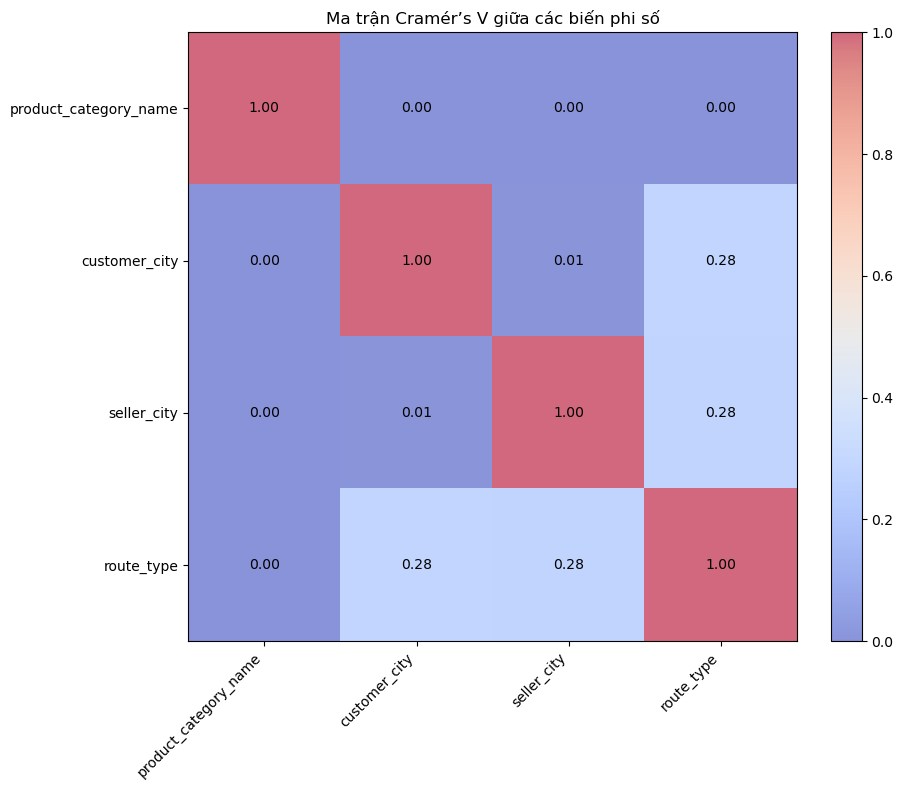

In [ ]:
# Ma trận Cramers' V xét mối quan hệ giữa các biến phi số
not_number_data = delivered_data.drop(columns = ['order_status','order_id', 'product_id', 'seller_id', 'customer_id','customer_unique_id','seller_zip_code_prefix','customer_zip_code_prefix']).select_dtypes(include='object')
cat_cols = not_number_data.columns
cramers_matrix = pd.DataFrame(
    np.zeros((len(cat_cols), len(cat_cols))),
    index=cat_cols,
    columns=cat_cols
)

for col1 in cat_cols:
    for col2 in cat_cols:
        cramers_matrix.loc[col1, col2] = cramers_v(
            not_number_data[col1],
            not_number_data[col2]
        )
plt.figure(figsize=(10, 8))
im = plt.imshow(cramers_matrix.values, cmap="coolwarm", vmin=0, vmax=1, alpha=0.6)

plt.colorbar(im, fraction=0.046, pad=0.04)

plt.xticks(range(len(cat_cols)), cat_cols, rotation=45, ha="right")
plt.yticks(range(len(cat_cols)), cat_cols)

plt.title("Ma trận Cramér’s V giữa các biến phi số")

for i in range(len(cat_cols)):
    for j in range(len(cat_cols)):
        plt.text(j, i, f"{cramers_matrix.values[i, j]:.2f}",
                 ha="center", va="center")

plt.tight_layout()
plt.show()


Không có mối quan hệ rõ ràng giữa các biến phi số

# 4. Feature Engineering

In [ ]:
delivered_data.columns

StatementMeta(, 70b6eae9-aaeb-442b-94e4-6cfce5628bb2, 54, Finished, Available, Finished)

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value', 'customer_id',
       'order_status', 'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'product_category_name',
       'product_price_vnd', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'seller_zip_code_prefix',
       'seller_city', 'delivery_time', 'distance_km', 'route_type',
       'purchase_dow', 'purchase_dom', 'purchase_month'],
      dtype='object')

In [ ]:
# Loại bỏ các biến giá khác, chỉ giữ lại `freight_value`
delivered_data = delivered_data.drop(columns = ['price','product_price_vnd'])
# Loại bỏ các biến id
id_cols = [x for x in delivered_data.columns if '_id' in x.lower()]
delivered_data = delivered_data.drop(columns = id_cols)
# Loại bỏ biến `order_status` do ở các bước làm sạch trước đó đã lọc các đơn hàng giao hàng thành công, nên giờ không cần thiết cột này
delivered_data = delivered_data.drop(columns = ['order_status'])
# Loại bỏ các biến timestamp
delivered_data = delivered_data.drop(columns = ['shipping_limit_date', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date'])
# Loại bỏ các biến zip_code
delivered_data = delivered_data.drop(columns = ['customer_zip_code_prefix', 'seller_zip_code_prefix'])
print(f"Các trường dữ liệu còn lại là:\n{delivered_data.columns.to_list()}")

StatementMeta(, 70b6eae9-aaeb-442b-94e4-6cfce5628bb2, 55, Finished, Available, Finished)

Các trường dữ liệu còn lại là:
['freight_value', 'product_category_name', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'customer_city', 'seller_city', 'delivery_time', 'distance_km', 'route_type', 'purchase_dow', 'purchase_dom', 'purchase_month']


In [ ]:
# Hợp nhất chiều cao và chiều dài sản phẩm thành 1 biến: `product_side_area`, chuyển đổi về m2 (thay vì cm2)
delivered_data['product_size'] = (delivered_data['product_length_cm']/10) * (delivered_data['product_height_cm']/10 * (delivered_data['product_width_cm']/10))
# Đổi đơn vị cân nặng sản phẩm từ gam sang kg
delivered_data['product_weight_kg'] = delivered_data['product_weight_g']/1000
# Xóa các cột thừa
delivered_data = delivered_data.drop(columns = ['product_length_cm', 'product_height_cm', 'product_width_cm', 'product_weight_g'])
print(f"Các trường dữ liệu còn lại là:\n{delivered_data.columns.to_list()}")
display(delivered_data.head())

StatementMeta(, 70b6eae9-aaeb-442b-94e4-6cfce5628bb2, 56, Finished, Available, Finished)

Các trường dữ liệu còn lại là:
['freight_value', 'product_category_name', 'customer_city', 'seller_city', 'delivery_time', 'distance_km', 'route_type', 'purchase_dow', 'purchase_dom', 'purchase_month', 'product_size', 'product_weight_kg']


SynapseWidget(Synapse.DataFrame, f6b1c7fe-156f-4676-b9e3-89147cf67b03)

In [ ]:
delivered_data[['purchase_dow', 'purchase_dom', 'purchase_month']].head()

StatementMeta(, 70b6eae9-aaeb-442b-94e4-6cfce5628bb2, 57, Finished, Available, Finished)

purchase_dow  purchase_dom  purchase_month
0             1            11               4
1             1            11               4
2             1            11               4
3             3            10               4
4             4             5               8

In [ ]:
delivered_data['product_category_name'].unique()

StatementMeta(, 70b6eae9-aaeb-442b-94e4-6cfce5628bb2, 58, Finished, Available, Finished)

array(['may_anh_may_quay_phim', 'thoi_trang_nu', 'sach_van_phong_pham',
       'suc_khoe_sac_dep', 'thoi_trang_nam', 'do_choi_me_be',
       'the_thao_du_lich', 'nha_cua_doi_song', 'may_tinh_laptop',
       'dien_thoai_phu_kien', 'thiet_bi_dien_tu'], dtype=object)

In [ ]:
print(f"=> Các biến độc lập: {delivered_data.drop(columns = ['delivery_time']).columns.to_list()}")
print(f"=> Biến phụ thuộc: `delivery_time`")

StatementMeta(, 70b6eae9-aaeb-442b-94e4-6cfce5628bb2, 59, Finished, Available, Finished)

=> Các biến độc lập: ['freight_value', 'product_category_name', 'customer_city', 'seller_city', 'distance_km', 'route_type', 'purchase_dow', 'purchase_dom', 'purchase_month', 'product_size', 'product_weight_kg']
=> Biến phụ thuộc: `delivery_time`


In [ ]:
# Phân tích thống kê dữ liệu cuối
print("Bảng thống kê các trường dữ liệu số của data:")
numeric_df = delivered_data.select_dtypes(include='number')
display(stats(numeric_df))

StatementMeta(, 70b6eae9-aaeb-442b-94e4-6cfce5628bb2, 60, Finished, Available, Finished)

Bảng thống kê các trường dữ liệu số của data:


SynapseWidget(Synapse.DataFrame, b0126ede-b1d0-4805-ab83-45e550c30bf0)

In [ ]:
# Lấy bảng thống kê các biến phi số
cat_summary = delivered_data.describe(exclude = ['number']).transpose()
# Tính thêm cột % của giá trị Top
cat_summary['top_percent'] = (cat_summary['freq'] / cat_summary['count']) * 100
# Sắp xếp theo mức độ phổ biến
print("Bảng thống kê các trường dữ liệu phi số của data:")
display(cat_summary.sort_values('unique').reset_index())

StatementMeta(, 70b6eae9-aaeb-442b-94e4-6cfce5628bb2, 61, Finished, Available, Finished)

Bảng thống kê các trường dữ liệu phi số của data:


SynapseWidget(Synapse.DataFrame, 40bce466-d74d-4920-a1e3-d423ec0b290d)

# 5. Xây dựng mô hình

Nhóm sử dụng 3 mô hình: Linear Regression, Random Forest Regressor, Gradient Boosting Regressor

## 5.1.Xác định phương pháp chuẩn hóa dữ liệu nào phù hợp

StatementMeta(, 70b6eae9-aaeb-442b-94e4-6cfce5628bb2, 62, Finished, Available, Finished)

SCALER METHOD        | RMSE (Trung bình) | Độ ổn định (Std)
------------------------------------------------------------
No Scaling (Raw)     | 0.8142            | 0.0007
StandardScaler       | 0.8114            | 0.0007
MinMaxScaler         | 0.8114            | 0.0007
RobustScaler         | 0.8114            | 0.0007


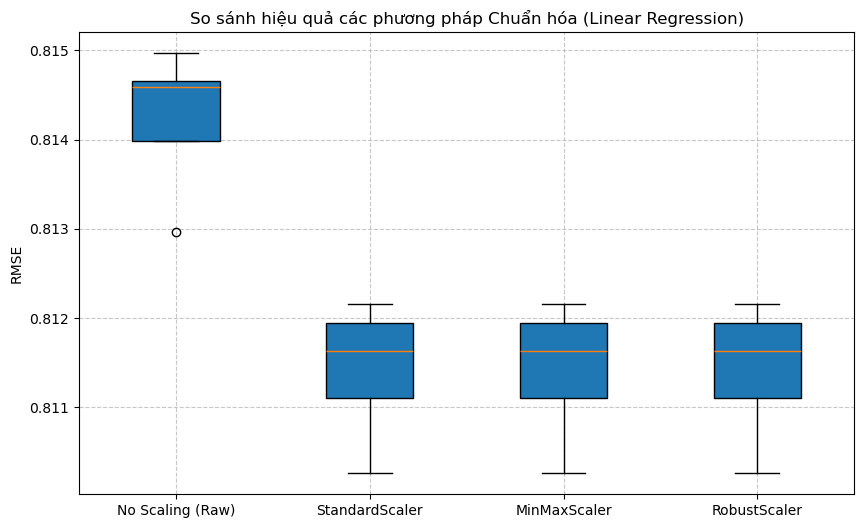

In [ ]:
# Định nghĩa các cột
y = delivered_data['delivery_time']
X = delivered_data.drop(columns = ['delivery_time'])
numeric_features = X.select_dtypes(include='number').columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()
# Danh sách các Scaler cần so sánh
scalers = {
    'No Scaling (Raw)': None, # Không làm gì cả
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler() # Chuyên trị outliers
}
results = []
names = []

print(f"{'SCALER METHOD':<20} | {'RMSE (Trung bình)':<15} | {'Độ ổn định (Std)'}")
print("-" * 60)

for name, scaler in scalers.items():
    # Cách xử lý các cột số
    if scaler is None:
        num_transformer = 'passthrough'
    else:
        num_transformer = scaler
    # 2. Tạo Preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', num_transformer, numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ])

    # Tạo pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', LinearRegression())])

    # Đánh giá bằng Cross-Validation (5-fold)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='neg_root_mean_squared_error')
    rmse_scores = -cv_scores
    results.append(rmse_scores)
    names.append(name)
    print(f"{name:<20} | {rmse_scores.mean():.4f}            | {rmse_scores.std():.4f}")
# trực quan
plt.figure(figsize=(10, 6))
plt.boxplot(results, labels=names, patch_artist=True)
plt.title('So sánh hiệu quả các phương pháp Chuẩn hóa (Linear Regression)')
plt.ylabel('RMSE')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

=> cả 3 phương pháp chuẩn hóa đều cho kết quả như nhau => chọn StandardScaler

## 5.2. Xác định mô hình nào là tốt nhất (với thông số mặc định)

In [ ]:
# Thiết lập Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', LinearRegression())])

# Thiết lập lưới tham số
param_grid = {
    'model__fit_intercept': [True, False],
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
start_time = time.time()

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=kf,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Huấn luyện
grid_search.fit(X, y)

end_time = time.time()
training_time = end_time - start_time
# Lấy kết quả tốt nhất
best_rmse = -grid_search.best_score_
best_params = grid_search.best_params_

print("-" * 60)
print(f"Kết quả model (Linear Regression):")
print(f"RMSE tốt nhất: {best_rmse:.4f}")
print(f"Thời gian tìm kiếm: {training_time:.4f}s")
print(f"Bộ tham số tối ưu: {best_params}")

StatementMeta(, 70b6eae9-aaeb-442b-94e4-6cfce5628bb2, 63, Finished, Available, Finished)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


------------------------------------------------------------
Kết quả model (Linear Regression):
RMSE tốt nhất: 0.8114
Thời gian tìm kiếm: 115.9781s
Bộ tham số tối ưu: {'model__fit_intercept': True}


In [ ]:
best_lr_model = grid_search.best_estimator_
y_pred_cv = cross_val_predict(best_lr_model, X, y, cv=kf)

mse = mean_squared_error(y, y_pred_cv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y, y_pred_cv)
mape = mean_absolute_percentage_error(y, y_pred_cv)*100
r2 = r2_score(y, y_pred_cv)*100

print("Kết quả đánh giá model:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R2 Score: {r2:.4f}%")
print(f"MAPE: {mape:.4f}%")

StatementMeta(, 70b6eae9-aaeb-442b-94e4-6cfce5628bb2, 68, Finished, Available, Finished)

Kết quả đánh giá model:
RMSE: 0.8114
MAE:  0.6620
R2 Score: 78.5675%
MAPE: 18.2868%


StatementMeta(, 70b6eae9-aaeb-442b-94e4-6cfce5628bb2, 69, Finished, Available, Finished)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


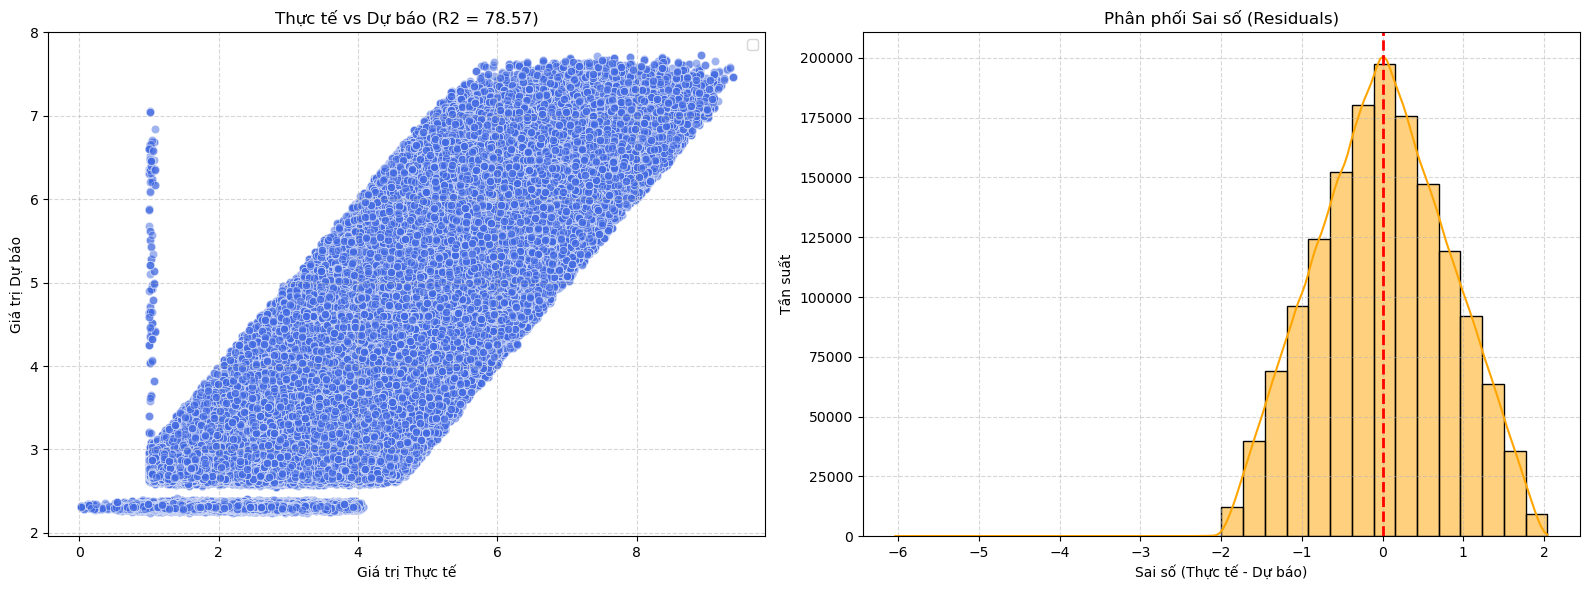

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.scatterplot(x=y, y=y_pred_cv, alpha=0.5, color='royalblue', ax=axes[0])
axes[0].set_title(f'Thực tế vs Dự báo (R2 = {r2:.2f})')
axes[0].set_xlabel('Giá trị Thực tế')
axes[0].set_ylabel('Giá trị Dự báo')
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.5)

residuals = y - y_pred_cv
sns.histplot(residuals, bins=30, kde=True, color='orange', ax=axes[1])
axes[1].axvline(0, color='red', linestyle='--', lw=2)
axes[1].set_title('Phân phối Sai số (Residuals)')
axes[1].set_xlabel('Sai số (Thực tế - Dự báo)')
axes[1].set_ylabel('Tần suất')
axes[1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [ ]:
# Dự báo trên toàn bộ dữ liệu đầu vào X
y_pred_full = best_lr_model.predict(X)

mse_full = mean_squared_error(y, y_pred_full)
rmse_full = np.sqrt(mse_full)
mae_full = mean_absolute_error(y, y_pred_full)
mape_full = mean_absolute_percentage_error(y, y_pred_full)*100
r2_full = r2_score(y, y_pred_full)*100

print("\n" + "="*60)
print("Kết quả đánh giá mô hình trên toàn bộ tập dữ liệu:")
print(f"RMSE: {rmse_full:.4f}")
print(f"MAE:  {mae_full:.4f}")
print(f"R2 Score: {r2_full:.4f}%")
print(f"MAPE: {mape_full:.4f}%")

StatementMeta(, 70b6eae9-aaeb-442b-94e4-6cfce5628bb2, 70, Finished, Available, Finished)


Kết quả đánh giá mô hình trên toàn bộ tập dữ liệu:
RMSE: 0.8113
MAE:  0.6620
R2 Score: 78.5722%
MAPE: 18.2848%


StatementMeta(, 70b6eae9-aaeb-442b-94e4-6cfce5628bb2, 73, Finished, Available, Finished)

Run ID     | Random State    | RMSE       | MAE        | R2 Score  
----------------------------------------------------------------------
1          | 0               | 0.8114     | 0.6620     | 0.7857
2          | 1               | 0.8114     | 0.6620     | 0.7857
3          | 2               | 0.8114     | 0.6620     | 0.7857
4          | 3               | 0.8114     | 0.6620     | 0.7857
5          | 4               | 0.8114     | 0.6620     | 0.7857
6          | 5               | 0.8114     | 0.6620     | 0.7857
7          | 6               | 0.8114     | 0.6620     | 0.7857
8          | 7               | 0.8114     | 0.6620     | 0.7857
9          | 8               | 0.8114     | 0.6620     | 0.7857
10         | 9               | 0.8114     | 0.6620     | 0.7857

Tổng hợp kết quả 10 lần chạy:
RMSE Trung bình: 0.8114  (Độ lệch chuẩn: 0.0000)
MAE Trung bình:  0.6620   (Độ lệch chuẩn: 0.0000)
R2 Trung bình:   0.7857    (Độ lệch chuẩn: 0.0000)


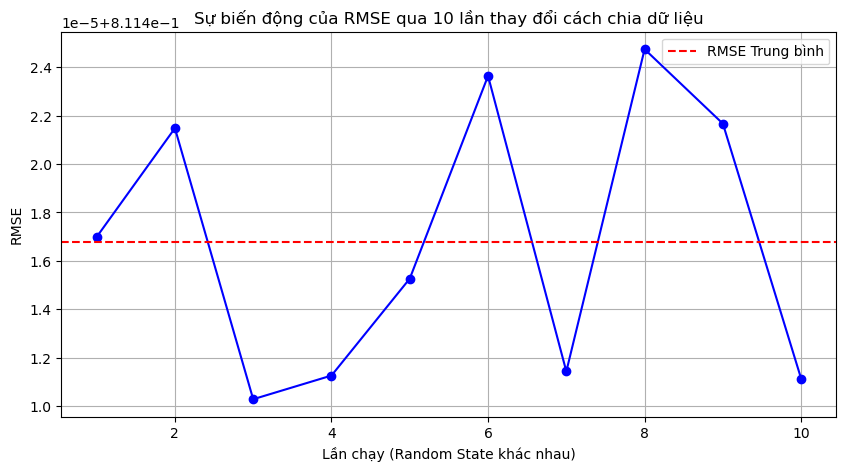

In [ ]:
# Danh sách 10 seeds ngẫu nhiên
random_states = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


results_stability = []

print(f"{'Run ID':<10} | {'Random State':<15} | {'RMSE':<10} | {'MAE':<10} | {'R2 Score':<10}")
print("-" * 70)


for i, seed in enumerate(random_states):
    kf_stability = KFold(n_splits=5, shuffle=True, random_state=seed)

    # 1. Tính RMSE
    rmse_scores = -cross_val_score(best_lr_model, X, y, cv=kf_stability, scoring='neg_root_mean_squared_error')
    avg_rmse = rmse_scores.mean()

    # 2. Tính MAE
    mae_scores = -cross_val_score(best_lr_model, X, y, cv=kf_stability, scoring='neg_mean_absolute_error')
    avg_mae = mae_scores.mean()

    # 3. Tính R2
    r2_scores = cross_val_score(best_lr_model, X, y, cv=kf_stability, scoring='r2')
    avg_r2 = r2_scores.mean()

    # Lưu kết quả
    results_stability.append({
        'Run_ID': i + 1,
        'Random_State': seed,
        'RMSE': avg_rmse,
        'MAE': avg_mae,
        'R2': avg_r2
    })

    print(f"{i+1:<10} | {seed:<15} | {avg_rmse:.4f}     | {avg_mae:.4f}     | {avg_r2:.4f}")

df_results = pd.DataFrame(results_stability)

print("\nTổng hợp kết quả 10 lần chạy:")
print(f"RMSE Trung bình: {df_results['RMSE'].mean():.4f}  (Độ lệch chuẩn: {df_results['RMSE'].std():.4f})")
print(f"MAE Trung bình:  {df_results['MAE'].mean():.4f}   (Độ lệch chuẩn: {df_results['MAE'].std():.4f})")
print(f"R2 Trung bình:   {df_results['R2'].mean():.4f}    (Độ lệch chuẩn: {df_results['R2'].std():.4f})")

StatementMeta(, 70b6eae9-aaeb-442b-94e4-6cfce5628bb2, 72, Finished, Available, Finished)

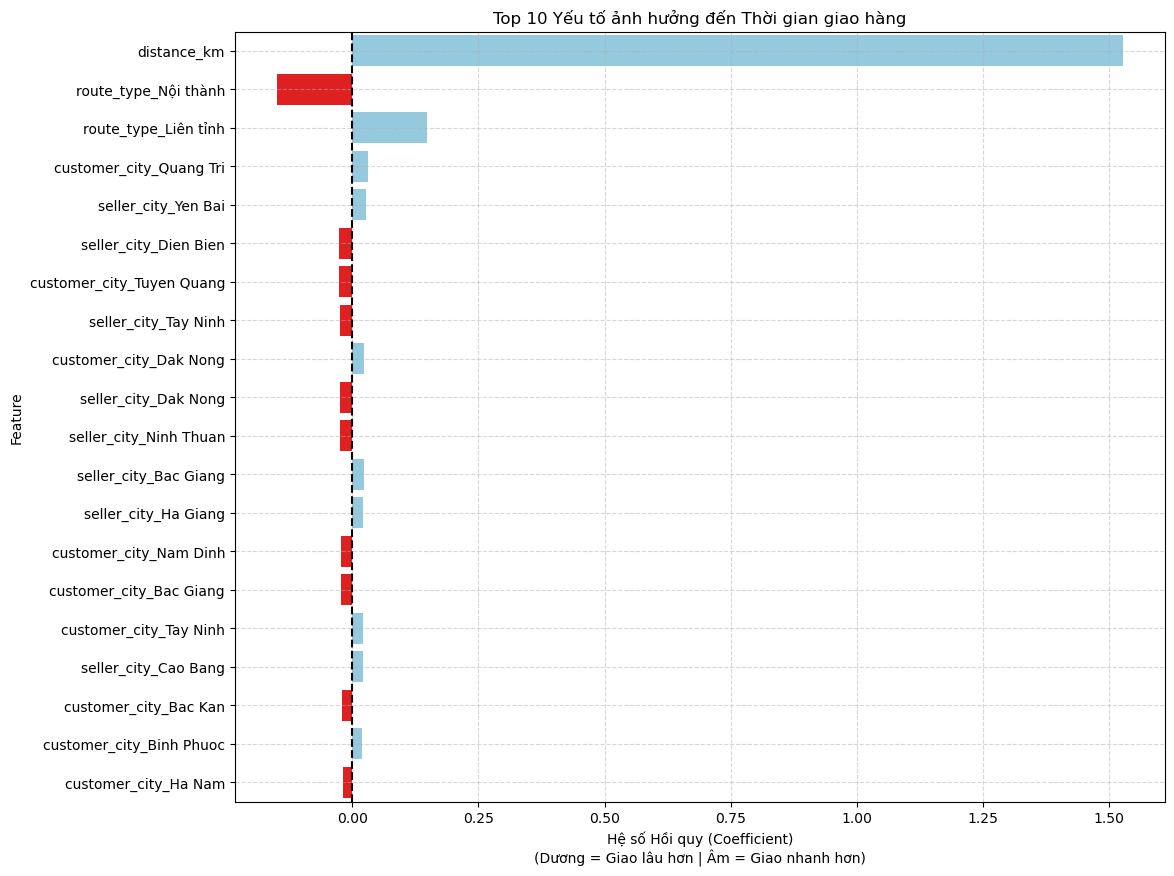

Chi tiết 10 yếu tố ảnh hưởng mạnh nhất:
                       Feature  Coefficient
1                  distance_km     1.526705
145       route_type_Nội thành    -0.149053
144       route_type_Liên tỉnh     0.149053
66     customer_city_Quang Tri     0.030608
143        seller_city_Yen Bai     0.027172
98       seller_city_Dien Bien    -0.025769
77   customer_city_Tuyen Quang    -0.025526
133       seller_city_Tay Ninh    -0.025137
34      customer_city_Dak Nong     0.024212
97        seller_city_Dak Nong    -0.023864


In [ ]:
# Lấy các bước từ pipeline tốt nhất
model_step = best_lr_model.named_steps['model']
preprocessor_step = best_lr_model.named_steps['preprocessor']

# Lấy tên các cột số (Numerical)
num_names = numeric_features

# Lấy tên các cột phân loại (Categorical) sau khi One-Hot Encoding
cat_transformer = preprocessor_step.named_transformers_['cat']
cat_names = cat_transformer.get_feature_names_out(categorical_features)
# Gộp lại thành danh sách đầy đủ theo đúng thứ tự
feature_names = np.r_[num_names, cat_names]
coefficients = model_step.coef_

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Tạo cột giá trị tuyệt đối để sắp xếp tầm quan trọng
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()

# Sắp xếp từ cao xuống thấp
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

plt.figure(figsize=(12, 10))

# Lấy top 10 đặc trưng ảnh hưởng mạnh nhất
top_10_features = coef_df.head(20)

# Vẽ biểu đồ cột ngang
# Dùng màu xanh cho hệ số dương (tăng thời gian), đỏ cho âm (giảm thời gian)
colors = ['red' if x < 0 else 'skyblue' for x in top_10_features['Coefficient']]
sns.barplot(x='Coefficient', y='Feature', data=top_10_features, palette=colors)

plt.title('Top 10 Yếu tố ảnh hưởng đến Thời gian giao hàng')
plt.xlabel('Hệ số Hồi quy (Coefficient)\n(Dương = Giao lâu hơn | Âm = Giao nhanh hơn)')
plt.axvline(0, color='black', linestyle='--')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

print("Chi tiết 10 yếu tố ảnh hưởng mạnh nhất:")
print(coef_df[['Feature', 'Coefficient']].head(10))

###